# Introduction
This project centers around the application of machine learning to train a robust model for accurate categorization of individuals into two groups: those who are likely to suffer a stroke and those who are not. To achieve the objective, we will:
* Perform EDA to uncover any patterns in the dataset;
* Visualize our findings in an appealing and comprehensive manner;
* Apply statistical testing procedures to the hypotheses that might arise during the formation of our problem;
* Train various types of machine learning models and evaluating based on the chosen criteria, select the best performing one.

We will be using "Stroke Prediction Dataset" from Kaggle, which can be found [here](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset).
## Defining the problem
A hospital requests you to create a machine learning model which could predict if the patient is likely to get a stroke. We need to determine which patients have a high stroke risk, as that would allow doctors to advise patients and their families with high risk how to act in case of an emergency.

Our goal will be to train a model with good recall without sacrificing too much precision as we want to be sure that we're not miss-classifying people with high risk of stroke to have a low risk. This would be an opportunity to consult with experts to gain an understanding of what they would consider a high risk, is it people who would have a risk over 50% to have a stroke or is it a lower number like 25% or a higher one like 75%? According to Heart Foundation in New Zealand, 10% risk is considered high [(link to their site)](https://www.heartfoundation.org.nz/wellbeing/managing-risk/your-risk), though it varies between roughly 10-15% over the next 5-10 years, depending on the source.
# Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
    GridSearchCV,
)
from sklearn.impute import KNNImputer
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import (
    OneHotEncoder,
    LabelBinarizer,
    StandardScaler,
    LabelEncoder,
)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import DBSCAN
from scipy.stats import (
    chi2_contingency,
    pointbiserialr,
    shapiro,
    probplot,
    boxcox,
    spearmanr,
)
from imblearn.over_sampling import RandomOverSampler
import warnings
from sklearn.exceptions import FitFailedWarning
from functions import cramers_v, drop_rows, remove_outliers

We'll start by reading in the data and checking whether we have any null values.

In [2]:
data = pd.read_csv("healthcare-dataset-stroke-data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


We have a unique identifier column and some null values, in the bmi column, so we will have to drop 'id' column and look at how to deal with NaNs, but before that lets split our data into train/test splits.

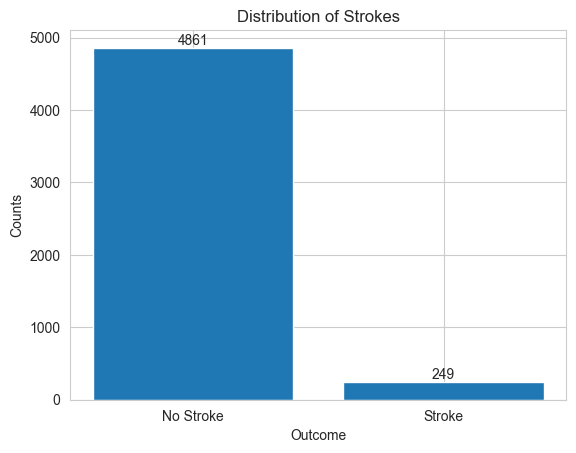

In [3]:
data.drop("id", axis=1, inplace=True)
data.rename(columns={col: col.lower() for col in data.columns}, inplace=True)
counts = data["stroke"].value_counts()
plt.bar(counts.index, counts.values)
for i, count in enumerate(counts.values):
    plt.text(i, count + 0.1, str(count), ha="center", va="bottom")
plt.xticks([0, 1], labels=["No Stroke", "Stroke"])
plt.xlabel("Outcome")
plt.ylabel("Counts")
plt.title("Distribution of Strokes");

The distribution of strokes is very unbalanced, therefore when splitting we'll split by stratifying on target.

In [4]:
x = data.drop("stroke", axis=1)
y = data["stroke"]
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=1, stratify=y
)
x_train_copy = x_train.copy()
x_train_copy.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status
2051,Female,35.0,0,0,Yes,Private,Rural,74.55,22.4,never smoked
2065,Male,19.0,0,0,No,Private,Urban,73.33,23.0,never smoked
1201,Male,46.0,0,0,Yes,Private,Urban,85.35,32.1,smokes
3918,Male,66.0,0,0,Yes,Self-employed,Rural,106.10,31.5,smokes
449,Male,42.0,0,0,Yes,Govt_job,Urban,68.19,31.0,never smoked


# Data Cleaning
We'll check unique values of columns that seem to be for categorical variables.

In [5]:
categorical_cols = [
    "gender",
    "hypertension",
    "heart_disease",
    "ever_married",
    "work_type",
    "residence_type",
    "smoking_status",
]
numerical_cols = ["age", "avg_glucose_level", "bmi"]
for column in categorical_cols:
    unique_values = x_train_copy[column].unique()
    print(f"{column}: {unique_values}")

gender: ['Female' 'Male' 'Other']
hypertension: [0 1]
heart_disease: [0 1]
ever_married: ['Yes' 'No']
work_type: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
residence_type: ['Rural' 'Urban']
smoking_status: ['never smoked' 'smokes' 'Unknown' 'formerly smoked']


We have some rows with without a specified gender, as well as unknown smoking status which could pose a problem, we should investigate that. Since we don't have all that many features, we'll be going over each of them manually, but first we'll check whether there are any duplicate rows.

In [6]:
x_train_copy.duplicated().sum()

0

Seems like we don't have any duplicate rows.
### Feature: gender

In [7]:
x_train_copy[x_train_copy["gender"] == "Other"]

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status
3116,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked


Seeing that there's only one person in our dataset whose gender is 'Other', there could be an argument made that we might want to remove this person from the dataset as it might reduce the performance of our model, increase its complexity for little to no benefit. Even if we left this row in the dataset, the model would not have enough data to correctly predict the chance of stroke for this type of person, if there was a significant difference for this group's chances of having a stroke, which we cannot prove without more data. Ultimately at a point when we would have more data where this occurrence is more common we would include it in our model, however now we will be removing it.

In [8]:
x_train_copy, y_train = drop_rows(
    x_train_copy, y_train, x_train_copy["gender"] == "Other"
)
gender_2d = x_train_copy["gender"].values.reshape(-1, 1)
one_hot_encoder = OneHotEncoder()
one_hot_encoded = one_hot_encoder.fit_transform(gender_2d).toarray()
one_hot_df = pd.DataFrame(
    one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(["gender"])
)
one_hot_df.index = x_train_copy.index
x_train_copy = pd.concat([x_train_copy, one_hot_df], axis=1).drop("gender", axis=1)

### Feature: age

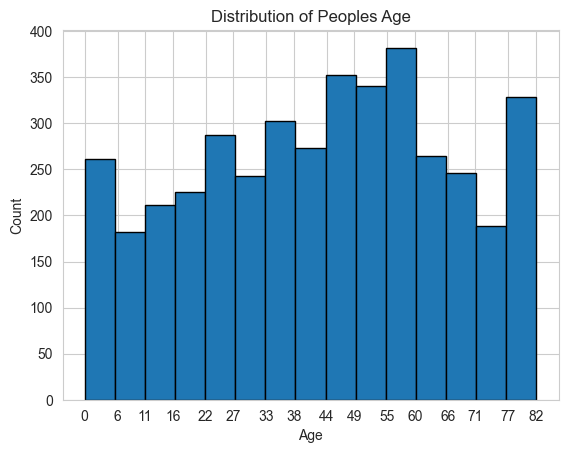

In [9]:
n, bins, edges = plt.hist(x_train_copy["age"], bins=15, ec="black")
plt.xticks(np.round(bins))
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Distribution of Peoples Age");

Looking at the age feature all the values seem to be within reasonable range of values, so no outliers here.
### Feature: ever married

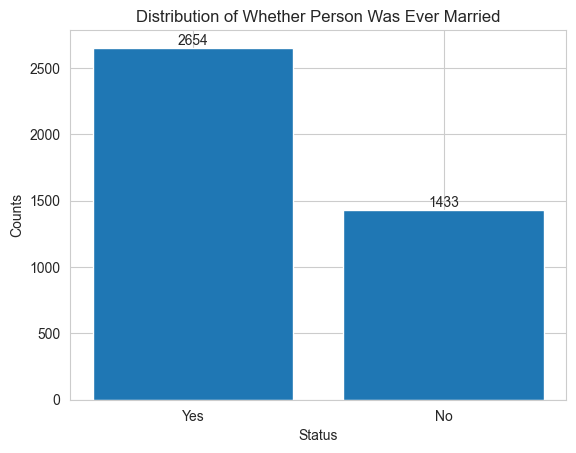

In [10]:
counts = x_train_copy["ever_married"].value_counts()
plt.bar(counts.index, counts.values)
for i, count in enumerate(counts.values):
    plt.text(i, count + 0.1, str(count), ha="center", va="bottom")
plt.xlabel("Status")
plt.ylabel("Counts")
plt.title("Distribution of Whether Person Was Ever Married");

Most people in the dataset were or are married. We'll encode the 'ever_married' feature into 1s and 0s and move on to 'work_type' feature.

In [11]:
binarizer = LabelBinarizer()
x_train_copy["ever_married"] = binarizer.fit_transform(x_train_copy["ever_married"])

### Feature: work type

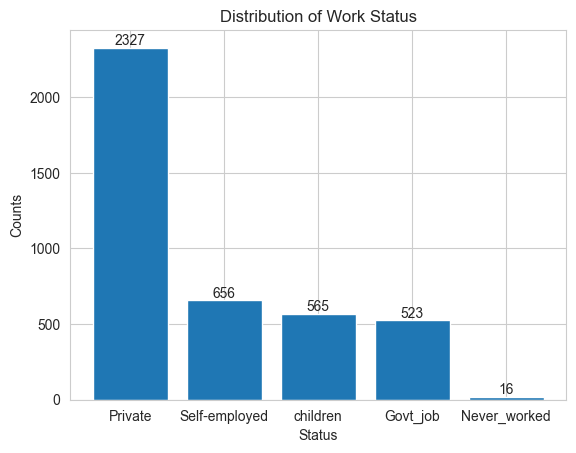

In [12]:
counts = x_train_copy["work_type"].value_counts()
plt.bar(counts.index, counts.values)
for i, count in enumerate(counts.values):
    plt.text(i, count + 0.1, str(count), ha="center", va="bottom")
plt.xlabel("Status")
plt.ylabel("Counts")
plt.title("Distribution of Work Status");

 There are people who have never worked, and people with children status, which might be a good idea to move all the people with "children" status to "Never_worked".

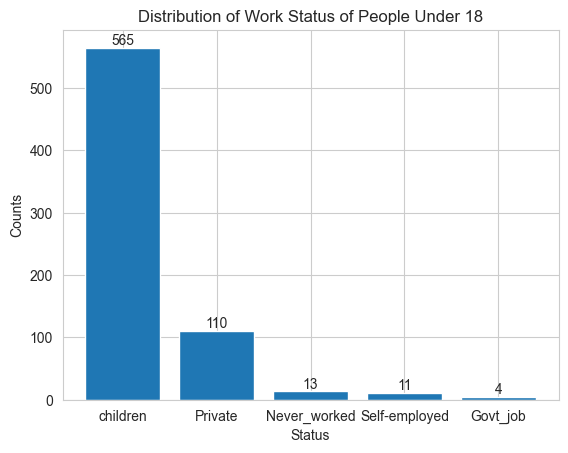

In [13]:
counts = x_train_copy[x_train_copy["age"] < 18]["work_type"].value_counts()
plt.bar(counts.index, counts.values)
for i, count in enumerate(counts.values):
    plt.text(i, count + 0.1, str(count), ha="center", va="bottom")
plt.xlabel("Status")
plt.ylabel("Counts")
plt.title("Distribution of Work Status of People Under 18");

We can see that some people under 18, are currently employed, we can look at the distributions of strokes across different work types and whether working in that position might have an effect even if they are not working that position for a long time.

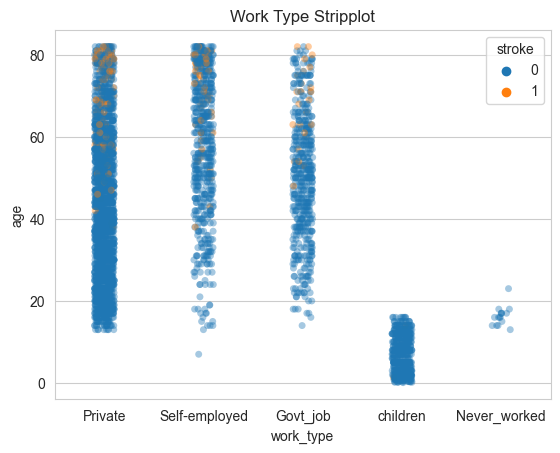

In [14]:
x_joined = x_train_copy.join(y_train)
sns.stripplot(x_joined, x="work_type", y="age", hue="stroke", alpha=0.4)
plt.title("Work Type Stripplot");

We see that strokes tend to start occurring only at roughly age 40, thus there is no reason to have a separate category for children, furthermore, it might be a good idea, to categorize people into age groups. Also, we might want to perform a chi-square test to check whether the distribution of people who have had a stroke is different, between different work types, because if they are not, there is no reason to differentiate people into work type groups.
So we'll define the null hypothesis as **H(0)**: There is no significant difference between the distributions of people in different work type groups and having a stroke. The alternative hypothesis would be that **H(a)**: there is a significant difference between those distributions. We'll choose a significance level of 0.05.

In [15]:
work_df = x_joined[
    x_joined["work_type"].isin(["Private", "Self-employed", "Govt_job"])
][["work_type", "stroke"]]
contingency_table = pd.crosstab(work_df["work_type"], work_df["stroke"])
_, p, _, _ = chi2_contingency(contingency_table)
print(f"P-value: {p}")

P-value: 0.0029015687288152796


Since we get the p-value lower than 0.05, we can reject the null hypothesis, in simple terms, saying that the distributions of people within different types of work in terms of having a stroke are different. Other than that we'll be merging children with the "Never_worked" category and one hot encoding work type and residence type features.

In [16]:
x_train_copy["work_type"].replace("children", "Never_worked", inplace=True)
work_type_before = x_train_copy["work_type"].copy()
work_type_2d = x_train_copy["work_type"].values.reshape(-1, 1)
one_hot_encoder = OneHotEncoder()
one_hot_encoded = one_hot_encoder.fit_transform(work_type_2d).toarray()
one_hot_df = pd.DataFrame(
    one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(["work_type"])
)
one_hot_df.index = x_train_copy.index
x_train_copy = pd.concat([x_train_copy, one_hot_df], axis=1).drop("work_type", axis=1)

### Feature: residence type

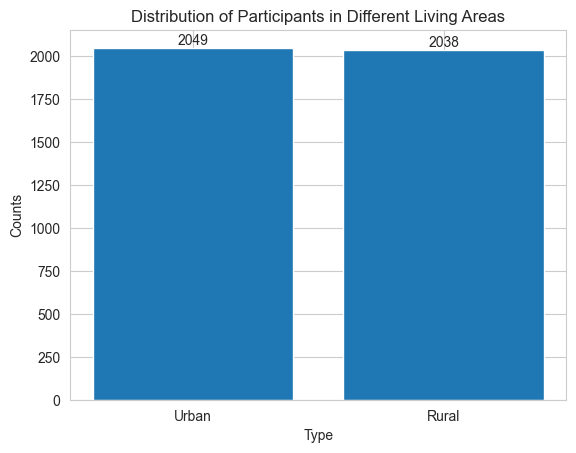

In [17]:
counts = x_train_copy["residence_type"].value_counts()
plt.bar(counts.index, counts.values)
for i, count in enumerate(counts.values):
    plt.text(i, count + 0.1, str(count), ha="center", va="bottom")
plt.xlabel("Type")
plt.ylabel("Counts")
plt.title("Distribution of Participants in Different Living Areas");

We see that there's pretty much equal distribution of people from both urban and rural areas.

In [18]:
residence_type_2d = x_train_copy["residence_type"].values.reshape(-1, 1)
one_hot_encoder = OneHotEncoder()
one_hot_encoded = one_hot_encoder.fit_transform(residence_type_2d).toarray()
one_hot_df = pd.DataFrame(
    one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(["residence_type"])
)
one_hot_df.index = x_train_copy.index
x_train_copy = pd.concat([x_train_copy, one_hot_df], axis=1).drop(
    "residence_type", axis=1
)

We'll continue looking at other features.
### Feature: average glucose levels

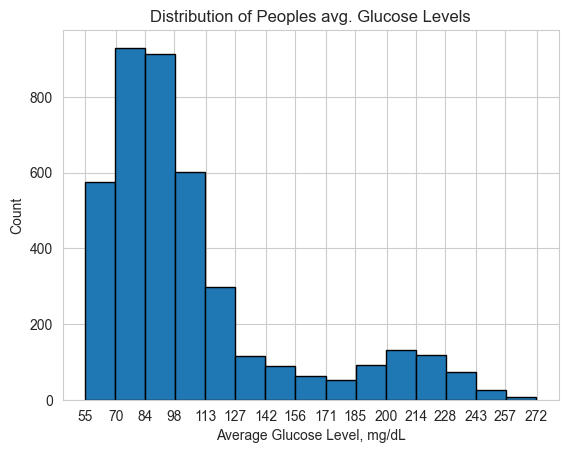

In [19]:
n, bins, edges = plt.hist(x_train_copy["avg_glucose_level"], bins=15, ec="black")
plt.xticks(np.round(bins))
plt.xlabel("Average Glucose Level, mg/dL")
plt.ylabel("Count")
plt.title("Distribution of Peoples avg. Glucose Levels");

We can see 2 distributions in this histogram, one on the left with a higher peak, of people who have lower average glucose levels and people on the right who seem to have higher average glucose levels. The left distribution seems like it's right skewed and distribution on the right seems like its normal. Generally normal blood glucose levels are considered to be between 70 and 100 mg/dL, so we have some people that are far from the norm with glucose levels from 113-272, possibly pointing that they might have some underlying condition like diabetes.
### Feature: bmi

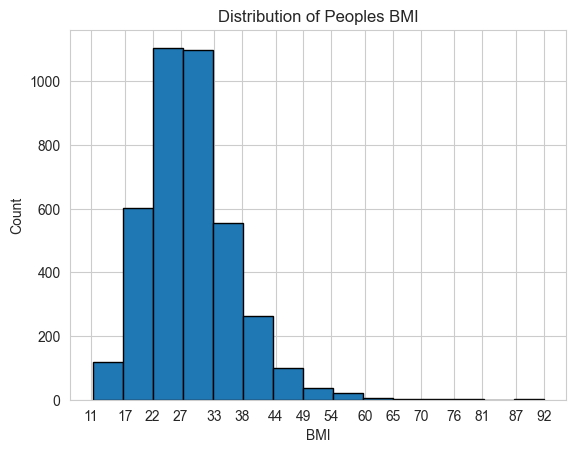

In [20]:
n, bins, edges = plt.hist(x_train_copy["bmi"], bins=15, ec="black")
plt.xticks(np.round(bins))
plt.xlabel("BMI")
plt.ylabel("Count")
plt.title("Distribution of Peoples BMI");

Generally bmi values are evaluated as: bmi <18.5 underweight, bmi 18.5-24.9 normal weight, bmi 25-29.9 overweight and bmi > 30 obesity [(source)](https://www.who.int/data/gho/data/themes/topics/topic-details/GHO/body-mass-index). Values over 60 seem abnormally high, thus we can guess that there might be some outliers in this data, which we should probably remove from our dataset.

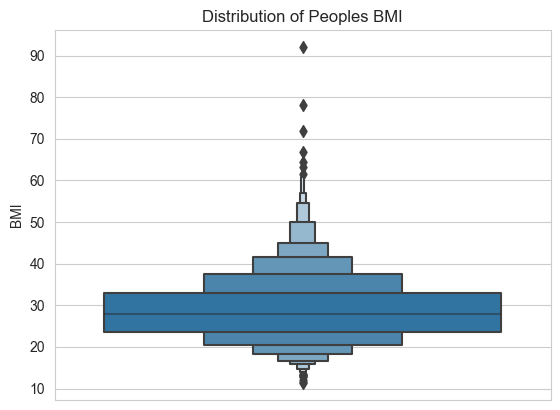

In [21]:
sns.boxenplot(x_train_copy["bmi"])
plt.ylabel("BMI")
plt.xticks([])
plt.title("Distribution of Peoples BMI");

In [22]:
x_train_copy["bmi"].isna().sum()

173

From the plot we can see that there are definitely some values that would be considered outliers we can use z-score method, or IQR method to find and remove them. Also, there are a few null values in the bmi column that we'll need to take care of and for that we'll use KNNImputer. We can also check how that impacts the correlation between our features.

In [23]:
y_bmi_corr = y_train.copy()
index_to_drop = x_train_copy[x_train_copy.isna().any(axis=1)].index.tolist()
x_bmi_corr = x_train_copy["bmi"].drop(index_to_drop)
y_encoded = y_bmi_corr.drop(index_to_drop)
corr, p_val = pointbiserialr(x_bmi_corr, y_encoded)
print(f"Point-biserial correlation coefficient: {corr}, p-value: {p_val}")

Point-biserial correlation coefficient: 0.04336818789071984, p-value: 0.006655461408451735


There doesn't seem to be a strong linear relationship between these two features.

In [24]:
x_train_copy, y_train, outlier = remove_outliers(x_train_copy, y_train, "bmi")

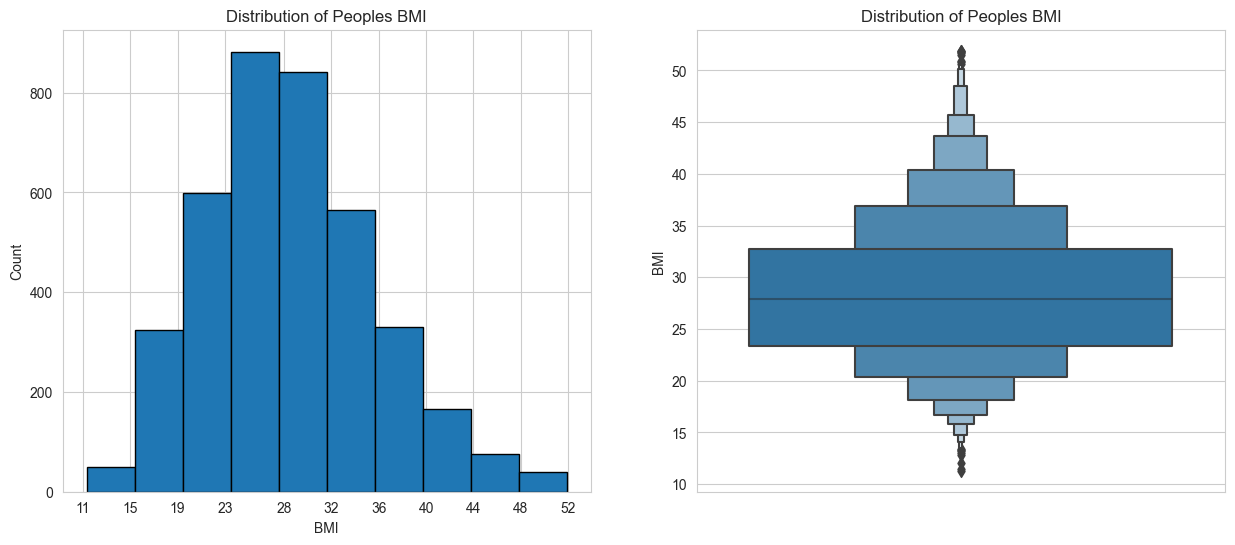

In [25]:
fix, ax = plt.subplots(1, 2, figsize=[15, 6])
n, bins, edges = ax[0].hist(x_train_copy["bmi"], bins=10, ec="black")
ax[0].set_xticks(np.round(bins))
ax[0].set_xlabel("BMI")
ax[0].set_ylabel("Count")
ax[0].set_title("Distribution of Peoples BMI")
sns.boxenplot(x_train_copy["bmi"], ax=ax[1])
ax[1].set_xticks([])
ax[1].set_ylabel("BMI")
ax[1].set_title("Distribution of Peoples BMI");

We see that normalized the distribution quite a bit, though I wouldn't claim that this is normal gaussian distribution, as it still somewhat right skewed.

In [26]:
y_bmi_corr = y_train.copy()
index_to_drop = x_train_copy[x_train_copy.isna().any(axis=1)].index.tolist()
x_bmi_corr = x_train_copy["bmi"].drop(index_to_drop)
y_encoded = y_bmi_corr.drop(index_to_drop)
corr, p_val = pointbiserialr(x_bmi_corr, y_encoded)
print(f"Point-biserial correlation coefficient: {corr}, p-value: {p_val}")

Point-biserial correlation coefficient: 0.05270419080019146, p-value: 0.001039954735935502


The correlation coefficient, after removing outliers, increased by a bit, but not by much. Next we'll be imputing null values.

In [27]:
before = x_train_copy["bmi"].describe()
x_train_copy_smoking = x_train_copy["smoking_status"]
x_train_copy_index = x_train_copy.index
x_train_copy_nan_index = x_train_copy[x_train_copy["bmi"].isna()].index.tolist()
x_train_copy.drop("smoking_status", axis=1, inplace=True)
bmi_imputer = KNNImputer(n_neighbors=5)
x_train_copy = pd.DataFrame(
    bmi_imputer.fit_transform(x_train_copy),
    index=x_train_copy.index,
    columns=x_train_copy.columns,
).join(x_train_copy_smoking)
after = x_train_copy["bmi"].describe()
bmi_diff = pd.concat([before, after], axis=1)
bmi_diff["diff"] = bmi_diff.iloc[:, 1] - bmi_diff.iloc[:, 0]
bmi_diff

,bmi,bmi,diff
count,3869.000000,4042.000000,173.000000
mean,28.465185,28.518214,0.053029
std,7.134806,7.046298,-0.088507
min,11.300000,11.300000,0.000000
25%,23.400000,23.500000,0.100000
50%,27.900000,28.000000,0.100000
75%,32.700000,32.700000,0.000000
max,51.900000,51.900000,0.000000


In [28]:
corr, p_val = pointbiserialr(x_train_copy["bmi"], y_train)
print(f"Point-biserial correlation coefficient: {corr}, p-value: {p_val}")

Point-biserial correlation coefficient: 0.05015066271536341, p-value: 0.0014255085574213045


While imputing the feature, I have removed smoking status column, due to 'unknown' statuses, so that it wouldn't affect the imputation. Looking at the difference, after the imputation, most of the metrics, like mean, median haven't changed by a lot, but it did reduce the correlation coefficient by a negligible amount. Overall we can say that there is no linear association between bmi and strokes.
### Feature: smoking status

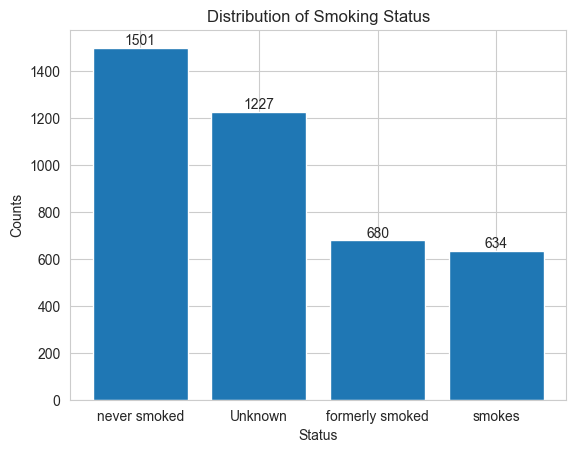

In [29]:
counts = x_train_copy["smoking_status"].value_counts()
plt.bar(counts.index, counts.values)
for i, count in enumerate(counts.values):
    plt.text(i, count + 0.1, str(count), ha="center", va="bottom")
plt.xlabel("Status")
plt.ylabel("Counts")
plt.title("Distribution of Smoking Status");

Unfortunately we have a lot of instances with unknown smoking status, which will most likely affect the model negatively as that category can be an amalgamation of the other 3 categories. Smoking is known to increase chances of having a stroke, so dropping this feature would be suboptimal, unfortunately, I don't believe we have a proxy feature by which we could tell whether the person is a smoker or not. When it comes to smoking, it increases your risk of stroke by increasing the blood pressure and reducing oxygen in the blood [(link to source)](https://strokefoundation.org.au/about-stroke/prevent-stroke/smoking). Allegedly, after stopping smoking the risk of stroke goes down and in a few years it becomes similar to that of a person who has not smoked, this would be good to confirm this with a domain expert. One last thing about this feature is that unfortunately we don't have the information of the intensity of smoking of smokers and people who have been formerly smoking as there could be a possibility that people who smoke far more, might have an increased risk of diseases. Next we will be one encoding the feature with One Hot Encoder and moving on to EDA.

In [30]:
without_unknown = x_train_copy.copy()
smoking_status_2d = x_train_copy["smoking_status"].values.reshape(-1, 1)
one_hot_encoder = OneHotEncoder()
one_hot_encoded = one_hot_encoder.fit_transform(smoking_status_2d).toarray()
one_hot_df = pd.DataFrame(
    one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(["smoking_status"])
)
one_hot_df.index = x_train_copy.index
x_train_copy = pd.concat([x_train_copy, one_hot_df], axis=1).drop(
    "smoking_status", axis=1
)

# Exploratory Data Analysis
We have mostly cleaned up our data, but that left us with a dataframe that's difficult to explore, so we'll make another copy of x_train dataframe and work with that.
### Gender distribution

In [31]:
x_train_eda = x_train.copy()
x_train_eda = x_train_eda.loc[x_train_copy.index]
x_train_eda["bmi"] = x_train_copy["bmi"]
x_train_eda_joined = x_train_eda.join(y_train)

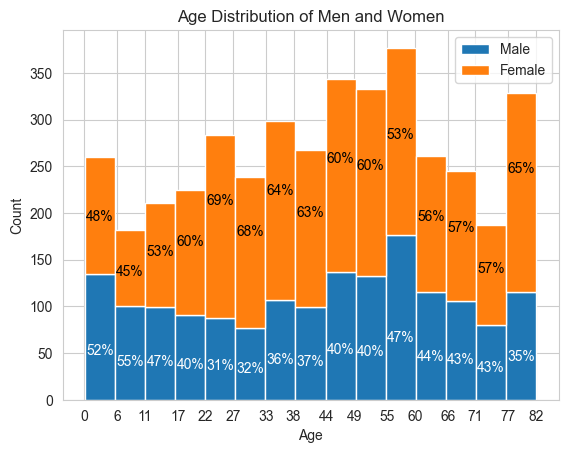

In [32]:
male_data = x_train_eda_joined[x_train_eda_joined["gender"] == "Male"]
female_data = x_train_eda_joined[x_train_eda_joined["gender"] == "Female"]

hist1, bins, _ = plt.hist(male_data["age"], bins=15, label="Male")
hist2, _, _ = plt.hist(female_data["age"], bins=bins, bottom=hist1, label="Female")

total_counts = hist1 + hist2
male_percentages = hist1 / total_counts * 100
female_percentages = hist2 / total_counts * 100

for i, (bin_value, male_percentage, female_percentage) in enumerate(
    zip(bins[:-1], male_percentages, female_percentages)
):
    plt.text(
        bin_value + (bins[i + 1] - bins[i]) / 2,
        total_counts[i] / 1.33,
        f"{female_percentage:.0f}%",
        ha="center",
        va="center",
        color="black",
    )
    plt.text(
        bin_value + (bins[i + 1] - bins[i]) / 2,
        hist1[i] / 3,
        f"{male_percentage:.0f}%",
        ha="center",
        va="bottom",
        color="white",
    )

plt.xticks(np.round(bins))
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution of Men and Women")
plt.legend();

Our dataset contains relatively similar numbers of both men and women, slight majority are women and most people in our dataset are middle age.

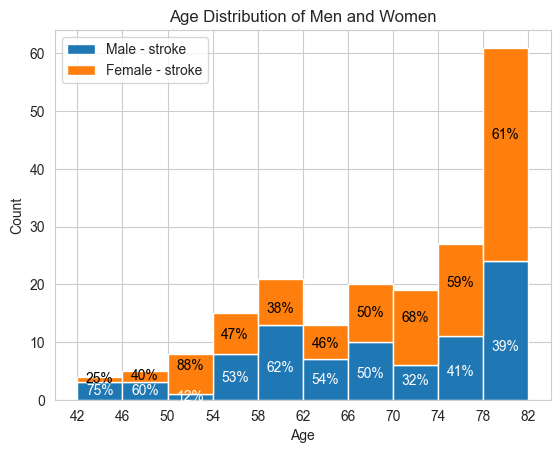

In [33]:
hist1, bins, _ = plt.hist(
    male_data["age"][male_data["stroke"] == 1], bins=10, label="Male - stroke"
)
hist2, _, _ = plt.hist(
    female_data["age"][female_data["stroke"] == 1],
    bins=bins,
    bottom=hist1,
    label="Female - stroke",
)

total_counts = hist1 + hist2
male_percentages = hist1 / total_counts * 100
female_percentages = hist2 / total_counts * 100

for i, (
    male_val,
    female_val,
    bin_value,
    male_percentage,
    female_percentage,
) in enumerate(zip(hist1, hist2, bins[:-1], male_percentages, female_percentages)):
    if male_val + female_val >= 10:
        plt.text(
            bin_value + (bins[i + 1] - bins[i]) / 2,
            total_counts[i] / 1.33,
            f"{female_percentage:.0f}%",
            ha="center",
            va="center",
            color="black",
        )
        plt.text(
            bin_value + (bins[i + 1] - bins[i]) / 2,
            hist1[i] / 3,
            f"{male_percentage:.0f}%",
            ha="center",
            va="bottom",
            color="white",
        )
    else:
        plt.text(
            bin_value + (bins[i + 1] - bins[i]) / 2,
            total_counts[i] / 1.7,
            f"{female_percentage:.0f}%",
            ha="center",
            va="bottom",
            color="black",
        )
        plt.text(
            bin_value + (bins[i + 1] - bins[i]) / 2,
            hist1[i] / 2,
            f"{male_percentage:.0f}%",
            ha="center",
            va="center",
            color="white",
        )

plt.xticks(np.round(bins))
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution of Men and Women")
plt.legend();

Generally as people get older, the rate at which people get strokes increases. At the same time far older women tend to have strokes at higher rates, whereas middle age men have strokes more often than middle age women.

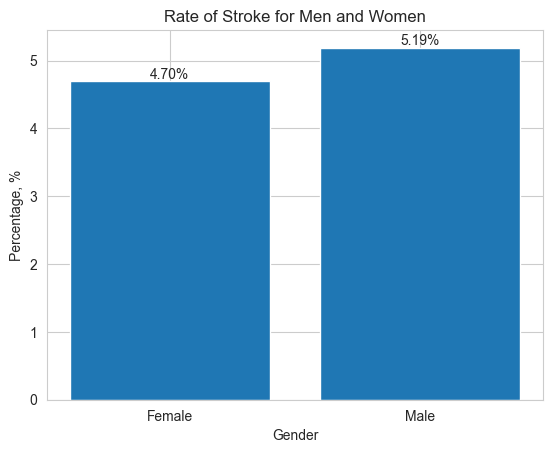

In [34]:
counts = (
    x_train_eda_joined[["gender", "stroke"]]
    .groupby("gender")
    .value_counts(normalize=True)
    * 100
).reset_index()
stroke = counts[counts["stroke"] == 1]
plt.bar(stroke["gender"], stroke["proportion"])
for i, count in enumerate(stroke["proportion"]):
    plt.text(i, count + 0.1, f"{count:.2f}%", ha="center", va="center")
plt.xlabel("Gender")
plt.ylabel("Percentage, %")
plt.title("Rate of Stroke for Men and Women");

However, overall men tend to have strokes at higher rates than women.
### Stroke distribution for people with hypertension or heart disease

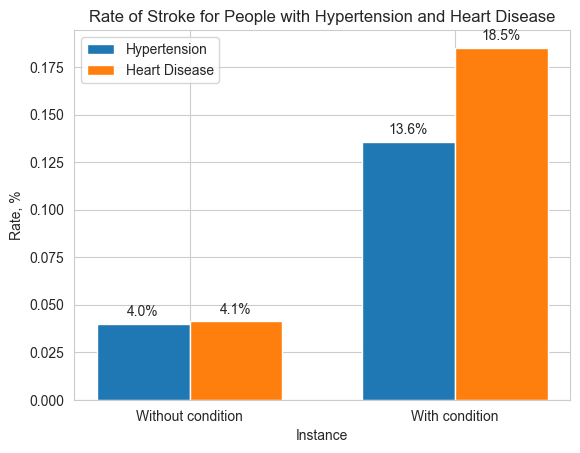

In [35]:
hypertension_counts = (
    x_train_eda_joined[["hypertension", "stroke"]]
    .groupby("hypertension")
    .value_counts(normalize=True)
    .reset_index()
)
heart_disease_counts = (
    x_train_eda_joined[["heart_disease", "stroke"]]
    .groupby("heart_disease")
    .value_counts(normalize=True)
    .reset_index()
)

bar_positions_hypertension = np.arange(
    len(hypertension_counts[hypertension_counts["stroke"] == 1])
)
bar_width = 0.35
bar_positions_heart_disease = bar_positions_hypertension + bar_width

plt.bar(
    bar_positions_hypertension,
    hypertension_counts[hypertension_counts["stroke"] == 1]["proportion"],
    width=bar_width,
    label="Hypertension",
)
plt.bar(
    bar_positions_heart_disease,
    heart_disease_counts[heart_disease_counts["stroke"] == 1]["proportion"],
    width=bar_width,
    label="Heart Disease",
)

for i, value in enumerate(
    hypertension_counts[hypertension_counts["stroke"] == 1]["proportion"]
):
    plt.text(
        bar_positions_hypertension[i],
        value + 0.01,
        f"{value*100:.1f}%",
        ha="center",
        va="top",
    )
for i, value in enumerate(
    heart_disease_counts[heart_disease_counts["stroke"] == 1]["proportion"]
):
    plt.text(
        bar_positions_heart_disease[i],
        value + 0.01,
        f"{value*100:.1f}%",
        ha="center",
        va="top",
    )

plt.xlabel("Instance")
plt.ylabel("Rate, %")
plt.title("Rate of Stroke for People with Hypertension and Heart Disease")
plt.xticks(
    bar_positions_hypertension + bar_width / 2,
    labels=["Without condition", "With condition"],
)
plt.legend();

We can see that having at least one of marked health conditions increases the rate of having a stroke roughly 3-5 times. We'll do another chi-square test to test whether there's a significant difference between the distributions of people with certain health conditions and people without them. Null hypothesis will be **H(0)**: There is no significant difference between the distributions of people between having a health condition (either heart disease or hypertension) and having a stroke. The alternative hypothesis would be that **H(a)**: there is a significant difference between those distributions. We'll choose a significance level of 0.05.

In [36]:
matrix = pd.crosstab(x_train_eda_joined["hypertension"], x_train_eda_joined["stroke"])
_, p, _, _ = chi2_contingency(matrix)
strength = cramers_v(matrix)
print(f"P-value {p:.2f}, strength of association: {strength:.2f}")

P-value 0.00, strength of association: 0.13


In [37]:
matrix = pd.crosstab(x_train_eda_joined["heart_disease"], x_train_eda_joined["stroke"])
_, p, _, _ = chi2_contingency(matrix)
strength = cramers_v(matrix)
print(f"P-value {p:.2f}, strength of association: {strength:.2f}")

P-value 0.00, strength of association: 0.15


There is significant relationship between both diseases and having a stroke, though the strength of the association is not very big.
### Distribution of avg. glucose levels and bmi

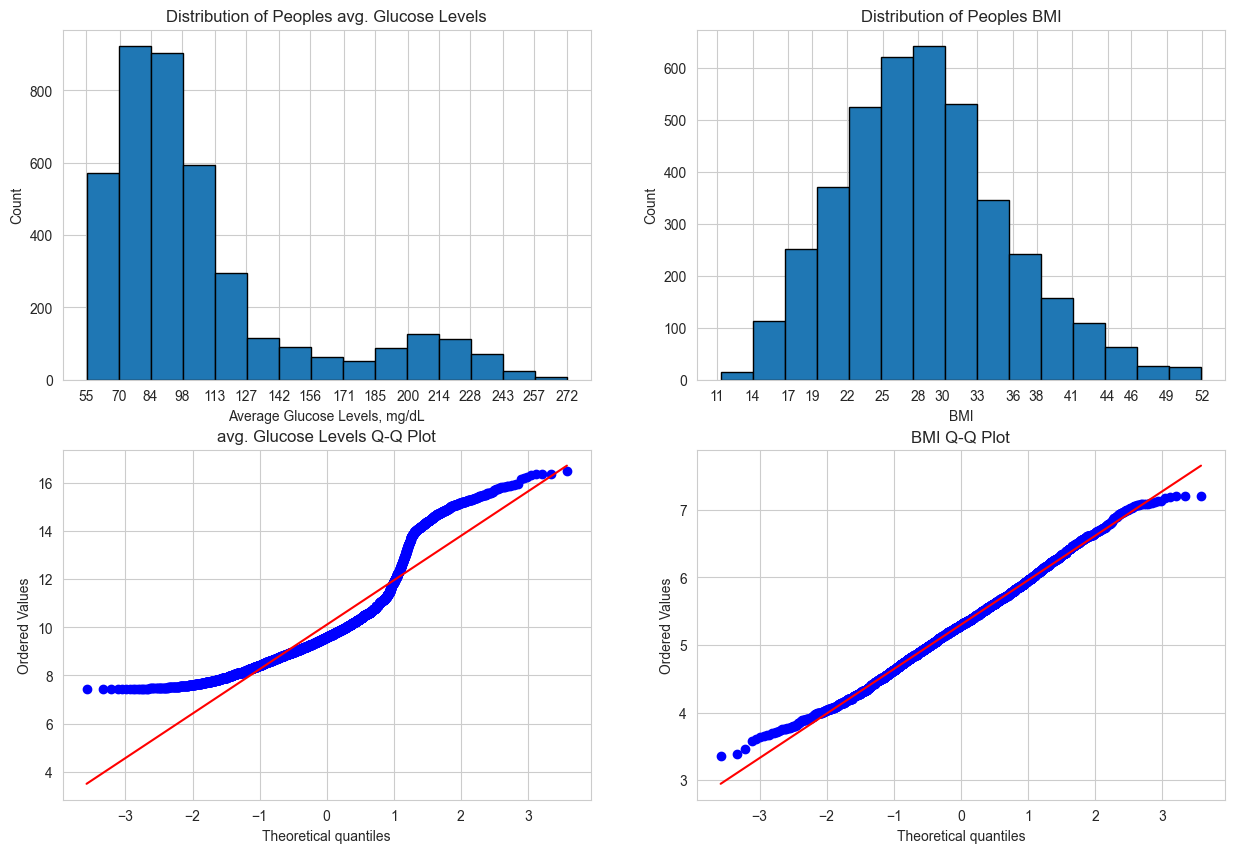

In [38]:
fig, ax = plt.subplots(2, 2, figsize=[15, 10])
n, bins, edges = ax[0, 0].hist(
    x_train_eda_joined["avg_glucose_level"], bins=15, ec="black"
)
ax[0, 0].set_xticks(np.round(bins))
ax[0, 0].set_xlabel("Average Glucose Levels, mg/dL")
ax[0, 0].set_ylabel("Count")
ax[0, 0].set_title("Distribution of Peoples avg. Glucose Levels")
n, bins, edges = ax[0, 1].hist(x_train_eda_joined["bmi"], bins=15, ec="black")
ax[0, 1].set_xticks(np.round(bins))
ax[0, 1].set_xlabel("BMI")
ax[0, 1].set_ylabel("Count")
ax[0, 1].set_title("Distribution of Peoples BMI")
probplot(np.sqrt(x_train_eda_joined["avg_glucose_level"]), dist="norm", plot=ax[1, 0])
ax[1, 0].set_title("avg. Glucose Levels Q-Q Plot")
probplot(np.sqrt(x_train_eda_joined["bmi"]), dist="norm", plot=ax[1, 1])
ax[1, 1].set_title("BMI Q-Q Plot");

Looking at the distributions of average glucose levels and bmi, we see that the average glucose level distribution consists of two peaks, possibly right skewed distribution on the left and normal distribution on the right. The bmi histogram seems like it's close to being normally distributed with a slight right skew. From the QQ plots we see that they are, indeed, not normally distributed. We'll conduct Shapiro-Wilk test for normality, null hypothesis would be **H(0)**: our data comes from a normal distribution. The alternative hypothesis would be that **H(a)**: our data does not come from a normal distribution. We'll choose a significance level of 0.05.

In [39]:
stat, p_value = shapiro(boxcox(x_train_eda_joined["bmi"])[0])
print(f"Shapiro-Wilk Test Statistic: {stat}, p-value: {p_value}")

Shapiro-Wilk Test Statistic: 0.9982454180717468, p-value: 0.0001800797035684809


After attempts of normalization, the distribution still cannot be considered normal.

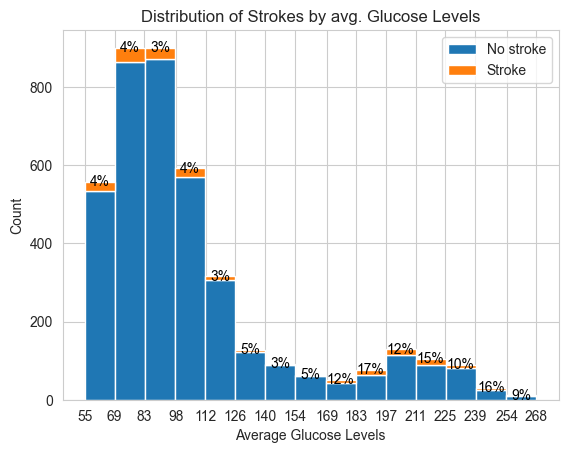

In [40]:
stroke_data = x_train_eda_joined[x_train_eda_joined["stroke"] == 1]
no_stroke_data = x_train_eda_joined[x_train_eda_joined["stroke"] == 0]

hist1, bins, _ = plt.hist(
    no_stroke_data["avg_glucose_level"], bins=15, label="No stroke"
)
hist2, _, _ = plt.hist(
    stroke_data["avg_glucose_level"], bins=bins, bottom=hist1, label="Stroke"
)

total_counts = hist1 + hist2
stroke_percentages = hist1 / total_counts * 100
no_stroke_percentages = hist2 / total_counts * 100

for i, (bin_value, stroke_percentage, no_stroke_percentage) in enumerate(
    zip(bins[:-1], stroke_percentages, no_stroke_percentages)
):
    plt.text(
        bin_value + (bins[i + 1] - bins[i]) / 2,
        total_counts[i],
        f"{no_stroke_percentage:.0f}%",
        ha="center",
        va="center",
        color="black",
    )

plt.xticks(np.round(bins))
plt.xlabel("Average Glucose Levels")
plt.ylabel("Count")
plt.title("Distribution of Strokes by avg. Glucose Levels")
plt.legend();

Coming back to the glucose histogram, we see that generally, the higher the glucose levels, the more people tend to have strokes. Higher stroke rates are distributed around the second peak.
### Cluster separation

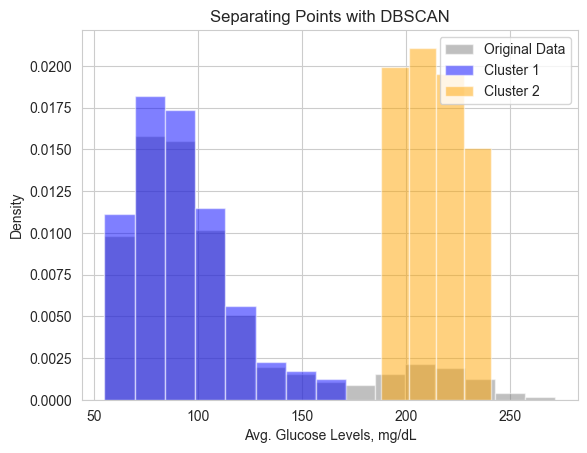

In [41]:
hist_data = np.array(x_train_eda_joined["avg_glucose_level"]).reshape(-1, 1)

dbscan = DBSCAN(eps=1.0)
labels = dbscan.fit_predict(hist_data)

cluster_1 = pd.DataFrame({"low_glucose": hist_data[labels == 0, 0]})
cluster_2 = pd.DataFrame({"high_glucose": hist_data[labels == 1, 0]})

plt.hist(
    hist_data, bins=15, density=True, alpha=0.5, color="gray", label="Original Data"
)
plt.hist(cluster_1, bins=8, density=True, alpha=0.5, color="blue", label="Cluster 1")
plt.hist(cluster_2, bins=4, density=True, alpha=0.5, color="orange", label="Cluster 2")

plt.xlabel("Avg. Glucose Levels, mg/dL")
plt.ylabel("Density")
plt.title("Separating Points with DBSCAN")
plt.legend();

DBSCAN identifies 2 clusters, as mentioned before, one for lower glucose levels and another for higher ones.

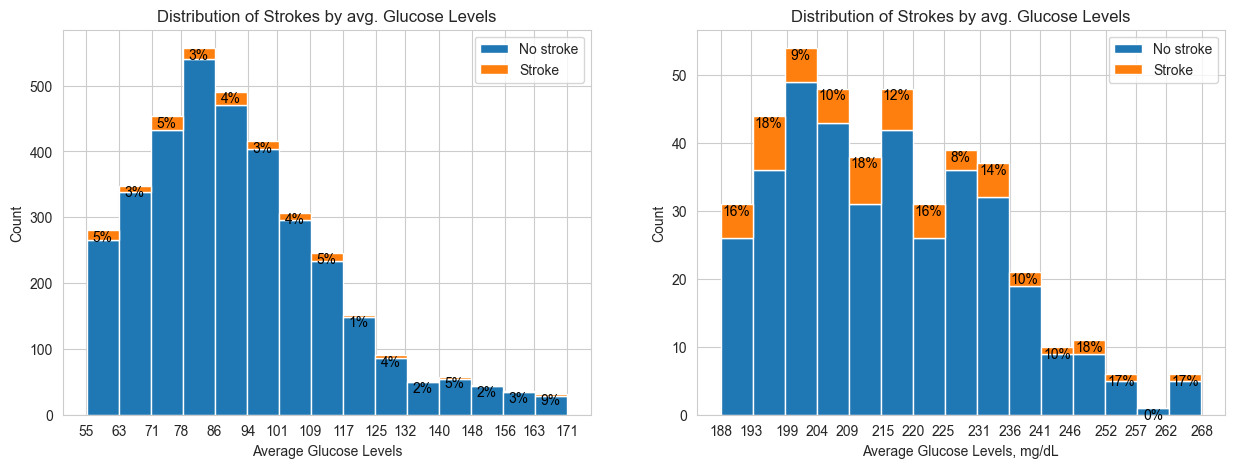

In [42]:
low_glucose = x_train_eda_joined[
    x_train_eda_joined["avg_glucose_level"] <= cluster_1.max().item()
]
high_glucose = x_train_eda_joined[
    x_train_eda_joined["avg_glucose_level"] >= cluster_2.min().item()
]
stroke_data_low = low_glucose[low_glucose["stroke"] == 1]
stroke_data_high = high_glucose[high_glucose["stroke"] == 1]
no_stroke_data_low = low_glucose[low_glucose["stroke"] == 0]
no_stroke_data_high = high_glucose[high_glucose["stroke"] == 0]

fig, ax = plt.subplots(1, 2, figsize=[15, 5])
hist1, bins, _ = ax[0].hist(
    no_stroke_data_low["avg_glucose_level"], bins=15, label="No stroke"
)
hist2, _, _ = ax[0].hist(
    stroke_data_low["avg_glucose_level"], bins=bins, bottom=hist1, label="Stroke"
)

total_counts = hist1 + hist2
stroke_percentages = hist1 / total_counts * 100
no_stroke_percentages = hist2 / total_counts * 100

for i, (bin_value, stroke_percentage, no_stroke_percentage) in enumerate(
    zip(bins[:-1], stroke_percentages, no_stroke_percentages)
):
    ax[0].text(
        bin_value + (bins[i + 1] - bins[i]) / 2,
        total_counts[i],
        f"{no_stroke_percentage:.0f}%",
        ha="center",
        va="top",
        color="black",
    )

ax[0].set_xticks(np.round(bins))
ax[0].set_xlabel("Average Glucose Levels")
ax[0].set_ylabel("Count")
ax[0].set_title("Distribution of Strokes by avg. Glucose Levels")
ax[0].legend()

hist1, bins, _ = ax[1].hist(
    no_stroke_data_high["avg_glucose_level"], bins=15, label="No stroke"
)
hist2, _, _ = ax[1].hist(
    stroke_data_high["avg_glucose_level"], bins=bins, bottom=hist1, label="Stroke"
)

total_counts = hist1 + hist2
stroke_percentages = hist1 / total_counts * 100
no_stroke_percentages = hist2 / total_counts * 100

for i, (bin_value, stroke_percentage, no_stroke_percentage) in enumerate(
    zip(bins[:-1], stroke_percentages, no_stroke_percentages)
):
    ax[1].text(
        bin_value + (bins[i + 1] - bins[i]) / 2,
        total_counts[i],
        f"{no_stroke_percentage:.0f}%",
        ha="center",
        va="top",
        color="black",
    )

ax[1].set_xticks(np.round(bins))
ax[1].set_xlabel("Average Glucose Levels, mg/dL")
ax[1].set_ylabel("Count")
ax[1].set_title("Distribution of Strokes by avg. Glucose Levels")
ax[1].legend();

Plotting the peaks separately and giving more room for different values, we see that the second distribution doesn't appear to be as normally distributed as it previously looked, though it's possible that we cut off some points from the second distribution.
### Relationships between continuous variables

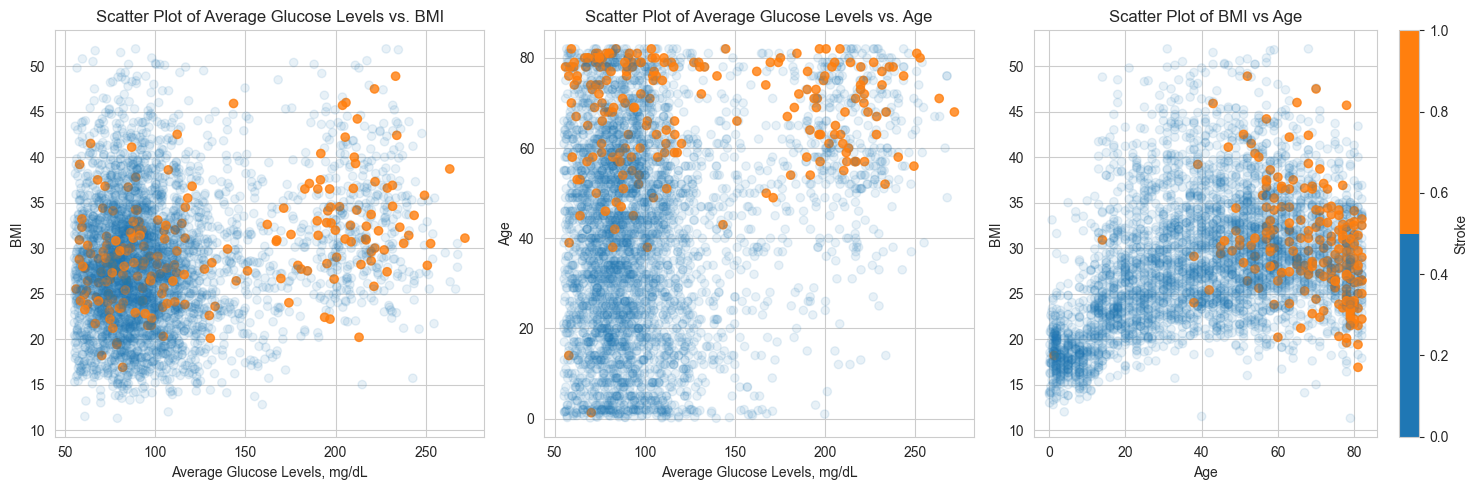

In [43]:
colors = ["C0", "C1"]
transparency_map = [
    0.8 if stroke == 1 else 0.1 for stroke in x_train_eda_joined["stroke"]
]
cmap = ListedColormap(colors)
fix, ax = plt.subplots(1, 3, figsize=[15, 5])
scatter1 = ax[0].scatter(
    x_train_eda_joined["avg_glucose_level"],
    x_train_eda_joined["bmi"],
    c=x_train_eda_joined["stroke"],
    cmap=cmap,
    alpha=transparency_map,
)
ax[0].set_xlabel("Average Glucose Levels, mg/dL")
ax[0].set_ylabel("BMI")
ax[0].set_title("Scatter Plot of Average Glucose Levels vs. BMI")
# ax[0].colorbar(label='Stroke')
scatter2 = ax[1].scatter(
    x_train_eda_joined["avg_glucose_level"],
    x_train_eda_joined["age"],
    c=x_train_eda_joined["stroke"],
    cmap=cmap,
    alpha=transparency_map,
)
ax[1].set_xlabel("Average Glucose Levels, mg/dL")
ax[1].set_ylabel("Age")
ax[1].set_title("Scatter Plot of Average Glucose Levels vs. Age")
# plt.colorbar(label='Stroke');
scatter3 = ax[2].scatter(
    x_train_eda_joined["age"],
    x_train_eda_joined["bmi"],
    c=x_train_eda_joined["stroke"],
    cmap=cmap,
    alpha=transparency_map,
)
ax[2].set_xlabel("Age")
ax[2].set_ylabel("BMI")
ax[2].set_title("Scatter Plot of BMI vs Age")
plt.colorbar(scatter3, label="Stroke", ax=ax[2])
plt.tight_layout();

There doesn't seem to be any linear relationship between the avg. glucose levels and BMI nor does there seem to be a pattern differentiating people who have strokes from the ones who don't. Looking at the second plot, we, again, don't see many patters, we can, though, notice two outlier at bottom left corner. Moving on to the last plot there's a relationship between bmi and age where bmi tends to increase with age, though that increase isn't linear and slows down at around age 20-30 and in terms of stroke, there might be some relationship between stroke and being older and having lower bmi, though if there is one, the relationship doesn't seem to be linear as in middle years (45-70) the variance of bmi in stroke patients is bigger, and thus it seems like it's more dependent on age, rather than having a strong relationship with bmi.
### Distributions of categorical variables

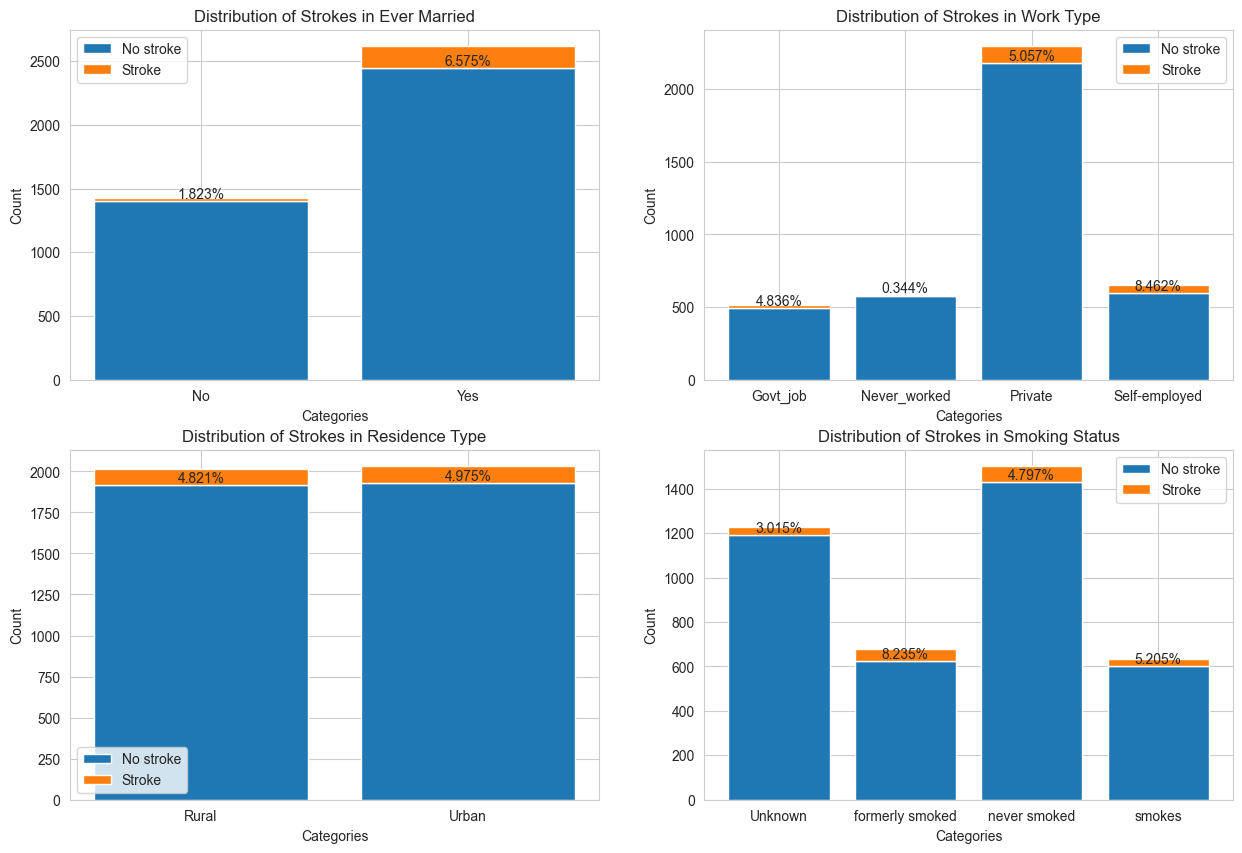

In [44]:
x_train_eda_joined = pd.concat(
    [x_train_eda_joined.drop("work_type", axis=1), work_type_before], axis=1
).dropna()
fig, ax = plt.subplots(2, 2, figsize=[15, 10])
for i, col in enumerate(categorical_cols[3:]):
    row, column = i // 2, i % 2
    counts = (
        x_train_eda_joined[[col, "stroke"]].groupby(col).value_counts().reset_index()
    )
    stroke = counts[counts["stroke"] == 1]
    no_stroke = counts[counts["stroke"] == 0]
    bottom_bar = ax[row, column].bar(
        no_stroke[col], no_stroke["count"], label="No stroke"
    )
    top_bar = ax[row, column].bar(
        stroke[col], stroke["count"], bottom=no_stroke["count"], label="Stroke"
    )
    counts = (
        x_train_eda_joined[[col, "stroke"]]
        .groupby(col)
        .value_counts(normalize=True)
        .reset_index()
    )
    stroke = counts[counts["stroke"] == 1]
    for bar, total_height, value in zip(
        top_bar, bottom_bar.patches, stroke["proportion"]
    ):
        ax[row, column].text(
            bar.get_x() + bar.get_width() / 2,
            total_height.get_height() + 0.01,
            f"{value:.3%}",
            ha="center",
            va="bottom",
        )
    ax[row, column].set_title(
        f"Distribution of Strokes in {col.replace('_', ' ').title()}"
    )
    ax[row, column].set_xlabel("Categories")
    ax[row, column].set_ylabel("Count")
    ax[row, column].legend()

From the first plot we see that married people tend to more often have strokes than unmarried people, one of the reasons might be that there are a lot of children in the dataset, and we saw that younger people tend to not have strokes, and thus it dilutes the population of unmarried people. It might be appropriate to remove children before plotting the histogram again. Looking at the second plot we see that people who have never worked tend not to have strokes, once again because most of them are young, whereas for the other categories self-employed people have the highest rate of stroke. In the 3rd plot both total amount of people and the distribution of strokes seems to be somewhat identical. Looking at the smoking status plot somewhat surprisingly people who used to smoke have the highest rate of stroke, and the rate for currently smoking people and people who never smoked doesn't seem to be very different.

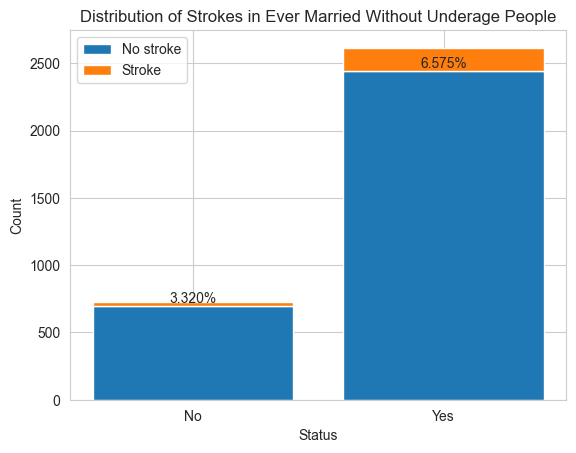

In [45]:
counts = (
    x_train_eda_joined[x_train_eda_joined["age"] >= 18][["ever_married", "stroke"]]
    .groupby("ever_married")
    .value_counts()
    .reset_index()
)
stroke = counts[counts["stroke"] == 1]
no_stroke = counts[counts["stroke"] == 0]
bottom_bar = plt.bar(no_stroke["ever_married"], no_stroke["count"], label="No stroke")
top_bar = plt.bar(
    stroke["ever_married"], stroke["count"], bottom=no_stroke["count"], label="Stroke"
)
counts = (
    x_train_eda_joined[x_train_eda_joined["age"] >= 18][["ever_married", "stroke"]]
    .groupby("ever_married")
    .value_counts(normalize=True)
    .reset_index()
)
stroke = counts[counts["stroke"] == 1]
for bar, total_height, value in zip(top_bar, bottom_bar.patches, stroke["proportion"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        total_height.get_height() + 0.01,
        f"{value:.3%}",
        ha="center",
        va="bottom",
    )
plt.title(f"Distribution of Strokes in Ever Married Without Underage People")
plt.xlabel("Status")
plt.ylabel("Count")
plt.legend();

After removing underage people from the dataset, the stroke rate has increased slightly, but it hasn't surpassed married people.

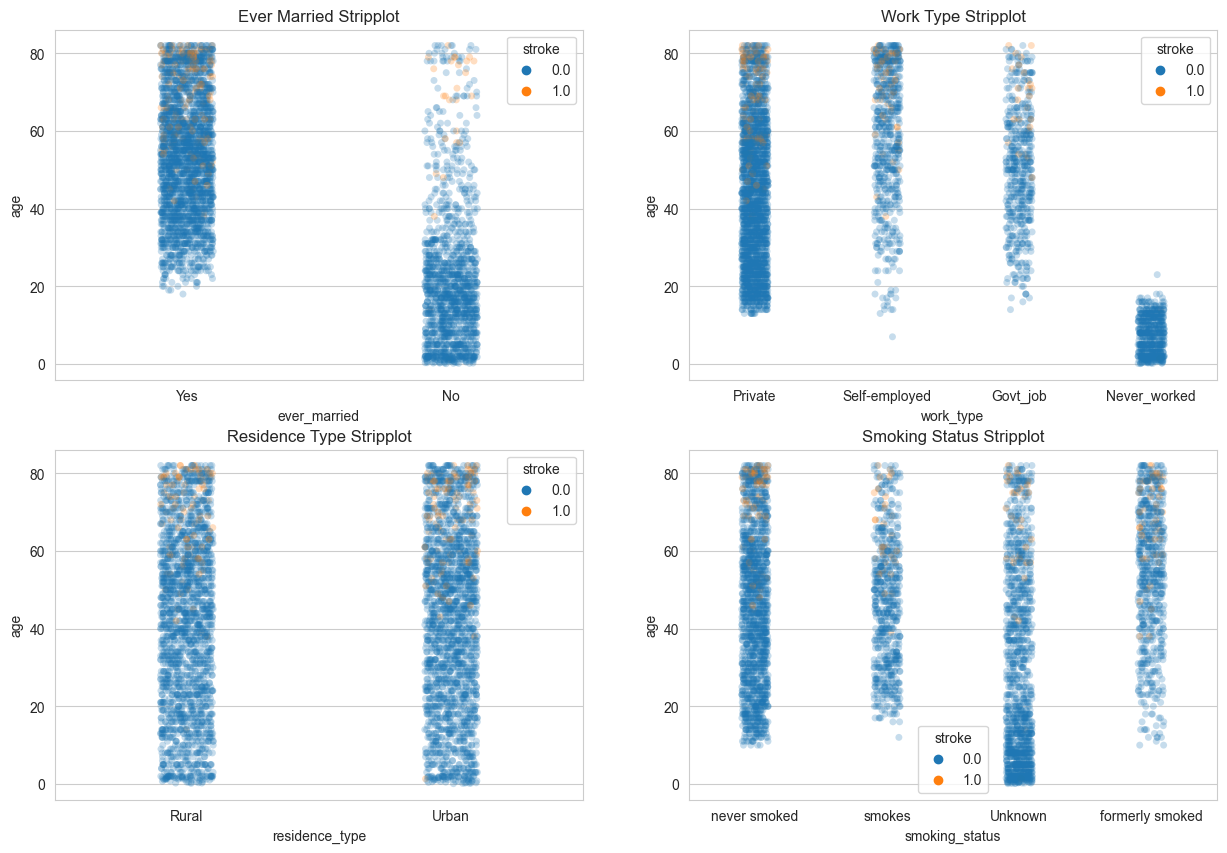

In [46]:
fig, ax = plt.subplots(2, 2, figsize=[15, 10])
for i, col in enumerate(categorical_cols[3:]):
    row, column = i // 2, i % 2
    sns.stripplot(
        x_train_eda_joined, x=col, y="age", hue="stroke", alpha=0.25, ax=ax[row, column]
    )
    ax[row, column].set_title(f"{col.replace('_', ' ').title()} Stripplot");

From the first plot we see that people only start marrying at higher rates at around 30-35, and we don't have that many strokes in people under 40 which majority are unmarried. Looking at the second plot, besides private workers and people who never worked (and children), self-employed people tend to cluster around older ages, whereas government workers are majority 40-60 years old. Once again, third plot doesn't seem to show much difference between these categories, which kind of begs whether this feature is relevant at all. And as for smoking status, we see that for people with unknown smoking status, there is a cluster of young people, which we know don't tend to get strokes, as for formerly smoked category they don't have that many young people and instead are mostly people age 50-80. We'll conduct another chi-square test to check whether the distribution of people from rural and urban residences have different distributions of stroke. We'll define the null hypothesis as **H(0)**: There is no significant difference between the distributions of people being from different residences and having a stroke. The alternative hypothesis would be that **H(a)**: there is a significant difference between those distributions. We'll choose a significance level of 0.05.

In [47]:
matrix = pd.crosstab(x_train_eda_joined["residence_type"], x_train_eda_joined["stroke"])
_, p, _, _ = chi2_contingency(matrix)
p

0.8773196358484262

After testing the two populations, the p-value is very high, thus we would not be able to reject the null hypothesis which would be that there is no difference between rural and urban populations and having strokes.
# Machine Learning
First we'll be trying few different approaches to get a baseline model and to check which features are relvant.

In [48]:
x_train_copy_u = without_unknown[without_unknown["smoking_status"] != "Unknown"]
smoking_status_2d = x_train_copy_u["smoking_status"].values.reshape(-1, 1)
one_hot_encoder = OneHotEncoder()
one_hot_encoded = one_hot_encoder.fit_transform(smoking_status_2d).toarray()
one_hot_df = pd.DataFrame(
    one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(["smoking_status"])
)
one_hot_df.index = x_train_copy_u.index
x_train_copy_u = pd.concat([x_train_copy_u, one_hot_df], axis=1).drop(
    "smoking_status", axis=1
)
y_train_u = y_train[x_train_copy_u.index]

We're making another version of training data, one without 'unknown' rows in smoking status feature, because I want to find out whether leaving it as unknown contributes at all and whether it'd be worthwhile categorizing it into the rest 3 categories.

              precision    recall  f1-score   support

           0       0.99      0.73      0.84      2654
           1       0.15      0.82      0.26       161

    accuracy                           0.73      2815
   macro avg       0.57      0.77      0.55      2815
weighted avg       0.94      0.73      0.80      2815



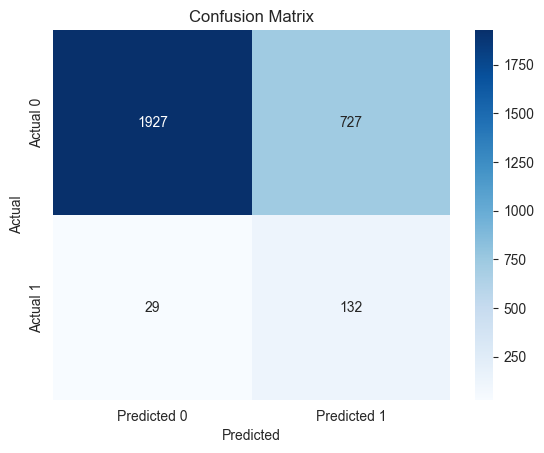

In [49]:
log_reg = LogisticRegression(class_weight="balanced", max_iter=1000)
log_reg.fit(x_train_copy_u, y_train_u)
y_pred = log_reg.predict(x_train_copy_u)
cm = confusion_matrix(y_train_u, y_pred)
report = classification_report(y_train_u, y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
print(report)

The first model that we're going to be using as the baseline will be a logistic regression model, and we're hoping to get at least precision of 0.15 and recall of 0.82. In this part we're not training a model to get the best model possible, but to get the importance of features, and observe how they change with different parameters.

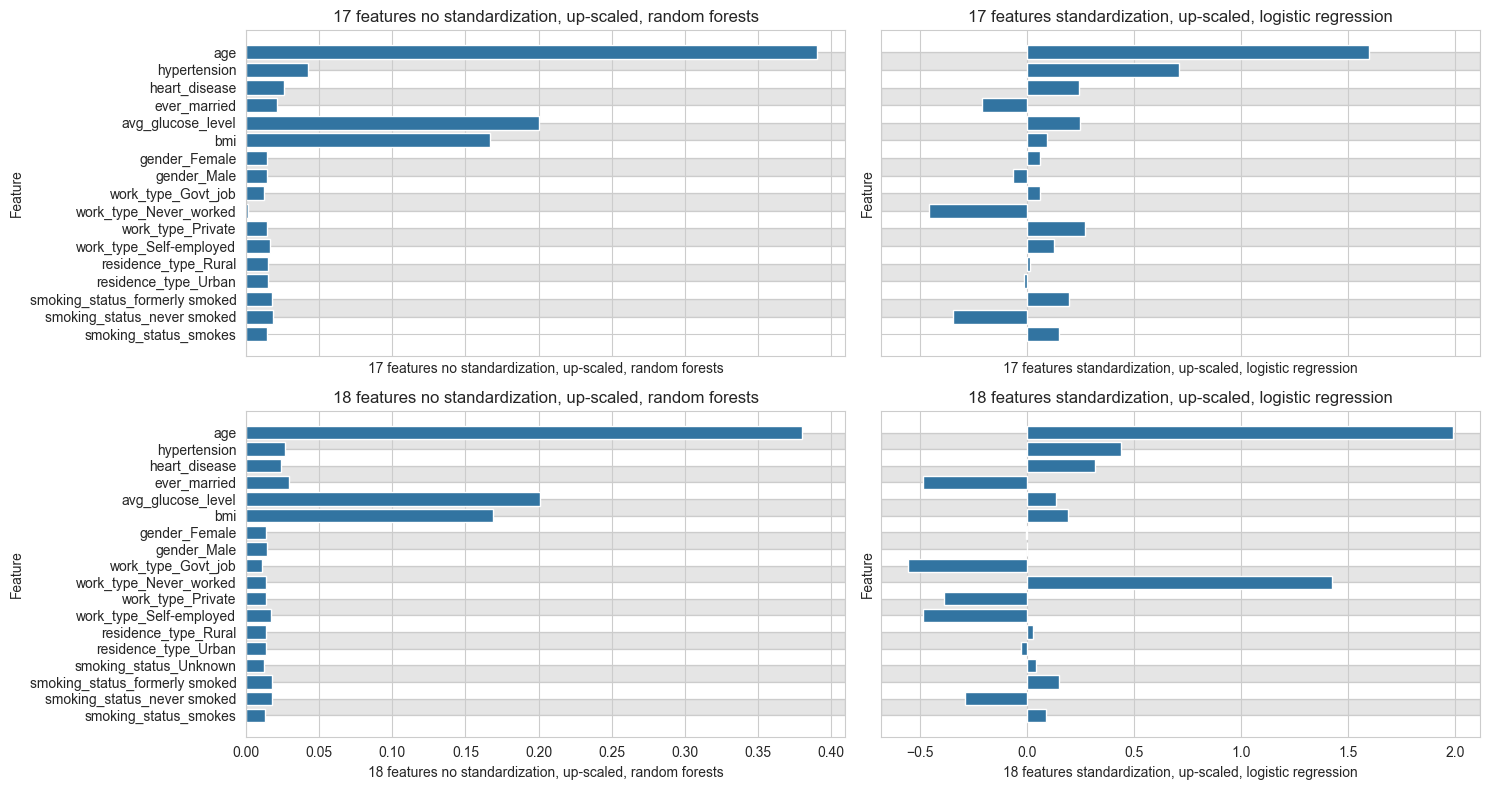

In [50]:
ros = RandomOverSampler(random_state=1)
x_resampled, y_resampled = ros.fit_resample(x_train_copy_u, y_train_u)
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=1)
random_forest_model.fit(x_resampled, y_resampled)
feature_importance17 = pd.DataFrame(
    {
        "Feature": x_train_copy_u.columns,
        "Value": random_forest_model.feature_importances_,
    }
)

scaler = StandardScaler()
x_resampled[["age", "avg_glucose_level", "bmi"]] = scaler.fit_transform(
    x_resampled[["age", "avg_glucose_level", "bmi"]]
)
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(x_resampled, y_resampled)
feature_importance17 = pd.concat(
    [feature_importance17, pd.DataFrame(log_reg.coef_[0])], axis=1
)

ros = RandomOverSampler(random_state=1)
x_resampled, y_resampled = ros.fit_resample(x_train_copy, y_train)
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=1)
random_forest_model.fit(x_resampled, y_resampled)
feature_importance18 = pd.DataFrame(
    {"Feature": x_train_copy.columns, "Value": random_forest_model.feature_importances_}
)

scaler = StandardScaler()
x_resampled[["age", "avg_glucose_level", "bmi"]] = scaler.fit_transform(
    x_resampled[["age", "avg_glucose_level", "bmi"]]
)
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(x_resampled, y_resampled)
feature_importance18 = pd.concat(
    [feature_importance18, pd.DataFrame(log_reg.coef_[0])], axis=1
)

feature_importance17.columns = [
    "Feature",
    "17 features no standardization, up-scaled, random forests",
    "17 features standardization, up-scaled, logistic regression",
]
feature_importance18.columns = [
    "Feature",
    "18 features no standardization, up-scaled, random forests",
    "18 features standardization, up-scaled, logistic regression",
]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8), sharex="col", sharey="row")

columns_to_plot_17 = feature_importance17.columns[1:]
for i, col in enumerate(columns_to_plot_17):
    sns.barplot(
        data=feature_importance17,
        x=col,
        y="Feature",
        color="C0",
        ax=axes[i // 2, i % 2],
    )
    axes[i // 2, i % 2].set_title(col)
    axes[i // 2, i % 2].grid(axis="y")
    yticks = axes[i // 2, i % 2].get_yticks()
    for y0, y1 in zip(yticks[::2], yticks[1::2]):
        axes[i // 2, i % 2].axhspan(y0, y1, color="black", alpha=0.1, zorder=0)
    axes[i // 2, i % 2].set_yticks(yticks)

columns_to_plot_18 = feature_importance18.columns[1:]
for i, col in enumerate(columns_to_plot_18):
    sns.barplot(
        data=feature_importance18,
        x=col,
        y="Feature",
        color="C0",
        ax=axes[(i + 2) // 2, (i + 2) % 2],
    )
    axes[(i + 2) // 2, (i + 2) % 2].set_title(col)
    axes[(i + 2) // 2, (i + 2) % 2].grid(axis="y")
    yticks = axes[(i + 2) // 2, (i + 2) % 2].get_yticks()
    for y0, y1 in zip(yticks[::2], yticks[1::2]):
        axes[(i + 2) // 2, (i + 2) % 2].axhspan(
            y0, y1, color="black", alpha=0.1, zorder=0
        )
    axes[(i + 2) // 2, (i + 2) % 2].set_yticks(yticks)

plt.tight_layout()

Comparing the random forests charts we see, that having smoking_status_Unknown feature, increases the importance of work_type_Never_worked feature, but seems like it slightly reduces the importance of other features, mostly hypertension. Comparing logistic regression feature importance, we see that having smoking_status_Unknown feature flips work type coefficients to have the opposite value (negative to positive and positive to negative) and slightly increases the importance of negative features, also gender features are less important. Overall, looking at logistic regression coefficients, the least important ones seem to be: gender, bmi, residence type and the unknown smoking status feature.

In [51]:
x1 = without_unknown.drop("smoking_status", axis=1)
y1 = without_unknown["smoking_status"][without_unknown["smoking_status"] != "Unknown"]
y2 = without_unknown["smoking_status"][without_unknown["smoking_status"] == "Unknown"]
x2 = x1[x1.index.isin(y2.index)]
x1 = x1[x1.index.isin(y1.index)]
x1_train, x1_test, y1_train, y1_test = train_test_split(
    x1, y1, test_size=0.2, random_state=1, stratify=y1
)
label_encoder = LabelEncoder()
y1_train = label_encoder.fit_transform(y1_train)
y1_test = label_encoder.transform(y1_test)
ros = RandomOverSampler(random_state=1)
x_resampled, y_resampled = ros.fit_resample(x1_train, y1_train)
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    max_depth=3,
    learning_rate=0.2,
    n_estimators=400,
)
param_grid = {
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0],
    "gamma": [0, 0.1, 0.2],
    "min_child_weight": [1, 3, 5],
}
grid_search = GridSearchCV(
    xgb_model, param_grid, cv=3, scoring="accuracy", verbose=2, n_jobs=-1
)
grid_search.fit(x_resampled, y_resampled)
xgb_model = grid_search.best_estimator_
cv = KFold(n_splits=5, shuffle=True, random_state=1)
cv_scores = cross_val_score(
    xgb_model, x_resampled, y_resampled, cv=cv, scoring="accuracy"
)
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())

Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
Cross-Validation Scores: [0.7517337  0.74895978 0.75866852 0.72222222 0.75277778]
Mean Accuracy: 0.746872399445215


1st model we'll try is XGBoost, we upscaled the minority class while training and tuning hyperparameters, after cross-validation we got accuracy of around 0.75.

In [52]:
scaler = StandardScaler()
x_resampled[["age", "avg_glucose_level", "bmi"]] = scaler.fit_transform(
    x_resampled[["age", "avg_glucose_level", "bmi"]]
)
param_grid = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", "auto"],
    "degree": [2, 3, 4],
    "class_weight": [None, "balanced"],
}
svc_model = SVC()
grid_search = GridSearchCV(
    svc_model, param_grid, cv=5, scoring="accuracy", verbose=2, n_jobs=-1
)
grid_search.fit(x_resampled, y_resampled)
svc_model = grid_search.best_estimator_
cv = KFold(n_splits=5, shuffle=True, random_state=1)
cv_scores = cross_val_score(
    svc_model, x_resampled, y_resampled, cv=cv, scoring="accuracy"
)
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Cross-Validation Scores: [0.50901526 0.47434119 0.51733703 0.49583333 0.49722222]
Mean Accuracy: 0.49874980736631225


2nd model we're trying is SVC, for which after cross-validation we got accuracy of around 0.5.

In [53]:
warnings.filterwarnings("ignore")
param_grid = {
    "penalty": ["l1", "l2"],
    "C": [0.001, 0.01, 0.1, 1, 10],
    "solver": ["liblinear", "lbfgs"],
    "max_iter": [100, 200, 300],
}
log_reg_model = LogisticRegression()
grid_search = GridSearchCV(
    log_reg_model, param_grid, cv=5, scoring="accuracy", verbose=2, n_jobs=-1
)
grid_search.fit(x_resampled, y_resampled)
log_reg_model = grid_search.best_estimator_
cv = KFold(n_splits=5, shuffle=True, random_state=1)
cv_scores = cross_val_score(
    log_reg_model, x_resampled, y_resampled, cv=cv, scoring="accuracy"
)
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())
warnings.resetwarnings()

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Cross-Validation Scores: [0.43411928 0.39667129 0.43550624 0.40972222 0.44583333]
Mean Accuracy: 0.4243704731083372


3rd model we tried was logistic regression model, for which after cross validation we got accuracy of around 0.42. Considering that XGBoost had the highest accuracy during cross-validation, we'll use the test set with that model.

              precision    recall  f1-score   support

           0       0.32      0.35      0.34       136
           1       0.54      0.57      0.56       300
           2       0.19      0.15      0.17       127

    accuracy                           0.42       563
   macro avg       0.35      0.36      0.35       563
weighted avg       0.41      0.42      0.42       563



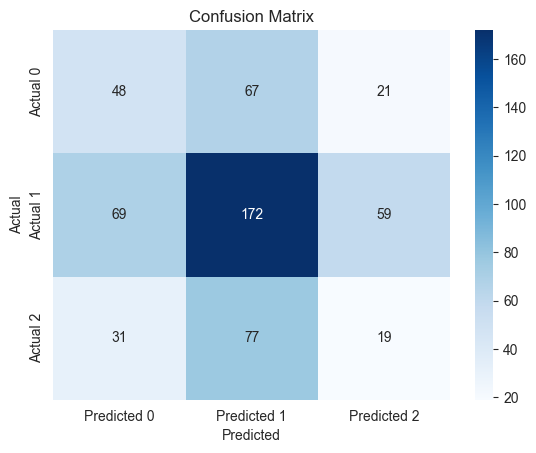

In [54]:
xgb_predictions = xgb_model.predict(x1_test)
xgb_cm = confusion_matrix(y1_test, xgb_predictions)
xgb_report = classification_report(y1_test, xgb_predictions)
sns.heatmap(
    xgb_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted 0", "Predicted 1", "Predicted 2"],
    yticklabels=["Actual 0", "Actual 1", "Actual 2"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
print(xgb_report)

We scored way lower accuracy on the test set, therefore we will not proceed with imputing the feature and will be dropping it altogether.
## Predicting stroke

In [55]:
x_train_copy.drop(
    [
        "smoking_status_formerly smoked",
        "smoking_status_never smoked",
        "smoking_status_smokes",
        "smoking_status_Unknown",
    ],
    axis=1,
    inplace=True,
)
x_train_new, x_val, y_train_new, y_val = train_test_split(
    x_train_copy, y_train, test_size=0.2, random_state=1, stratify=y_train
)

First we're dropping the smoking status feature, and splitting a part of our data off into a validation dataset, as some of the models were easy to over-fit.
### XGBoost

Cross-Validation Scores: [0.83548646 0.82400755 0.79414985 0.81814642 0.80774784]
Mean Recall: 0.8159076250968657
              precision    recall  f1-score   support

           0       0.98      0.73      0.84       769
           1       0.13      0.75      0.22        40

    accuracy                           0.74       809
   macro avg       0.56      0.74      0.53       809
weighted avg       0.94      0.74      0.81       809



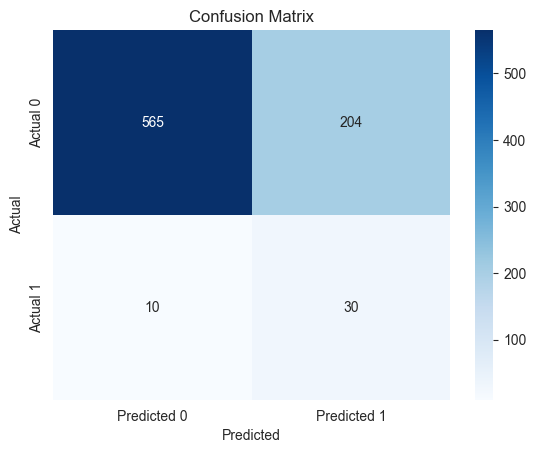

In [56]:
ros = RandomOverSampler(random_state=1)
x_resampled, y_resampled = ros.fit_resample(x_train_new, y_train_new)
xgb_model = xgb.XGBClassifier(objective="binary:logistic", num_class=1)
param_grid = {
    "learning_rate": [0.01, 0.05],
    "gamma": [0.1, 0.2],
    "n_estimators": [50, 75],
    "max_depth": [2, 3],
    "subsample": [0.6, 0.7],
    "colsample_bytree": [0.6, 0.8],
    "min_child_weight": [3, 5],
}
grid_search = GridSearchCV(
    xgb_model, param_grid, cv=3, scoring="recall_macro", n_jobs=-1
)
grid_search.fit(x_resampled, y_resampled)
xgb_model = grid_search.best_estimator_
cv = KFold(n_splits=5, shuffle=True, random_state=1)
cv_scores = cross_val_score(
    xgb_model, x_resampled, y_resampled, cv=cv, scoring="recall_macro"
)
print("Cross-Validation Scores:", cv_scores)
print("Mean Recall:", cv_scores.mean())
xgb_predictions = xgb_model.predict(x_val)
xgb_cm = confusion_matrix(y_val, xgb_predictions)
xgb_report = classification_report(y_val, xgb_predictions)
sns.heatmap(
    xgb_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
print(xgb_report)

Training XGBoost model yielded recall of 0.75 on the validation set. We see it's worse than during cross-validation, indicating slight over-fitting.

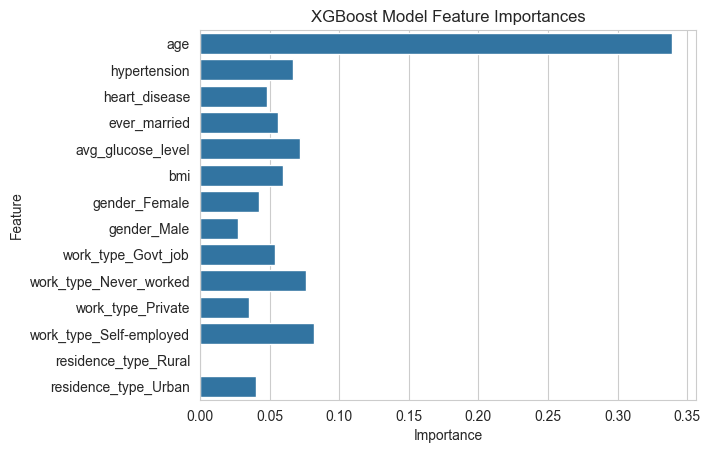

In [57]:
coefficients = xgb_model.feature_importances_
feature_importance = pd.DataFrame(zip(x_resampled.columns, coefficients))
sns.barplot(feature_importance, x=1, y=0, color="C0")
plt.title("XGBoost Model Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature");

Observing feature importance we see that the most important feature is age, while the rest, except for residence feature,  seem to be of roughly equal importance.
### LightGBM

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

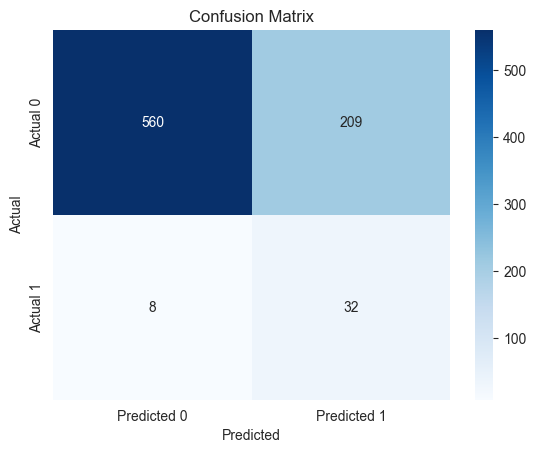

In [58]:
warnings.filterwarnings("ignore")
lgbm_model = lgb.LGBMClassifier(
    objective="binary",
    metric="binary_logloss",
    num_class=1,
    force_row_wise=True,
    learning_rate=0.01,
    verbosity=0,
)
param_grid = {
    "n_estimators": [50, 75],
    "max_depth": [2, 3],
    "subsample": [0.6, 0.7],
    "colsample_bytree": [0.6, 0.8],
    "min_child_weight": [3, 5],
    "num_leaves": [10, 15],
}
grid_search = GridSearchCV(
    lgbm_model, param_grid, cv=3, scoring="recall_macro", n_jobs=-1
)
grid_search.fit(x_resampled, y_resampled)
lgbm_model = grid_search.best_estimator_
cv = KFold(n_splits=5, shuffle=True, random_state=1)
cv_scores = cross_val_score(
    lgbm_model, x_resampled, y_resampled, cv=cv, scoring="recall_macro"
)
print("Cross-Validation Scores:", cv_scores)
print("Mean Recall:", np.mean(cv_scores))
lgbm_predictions = lgbm_model.predict(x_val)
lgbm_cm = confusion_matrix(y_val, lgbm_predictions)
lgbm_report = classification_report(y_val, lgbm_predictions)
sns.heatmap(
    lgbm_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
print(lgbm_report)
warnings.resetwarnings()

LightGBM model seems to do better, and it's less over-fitted.

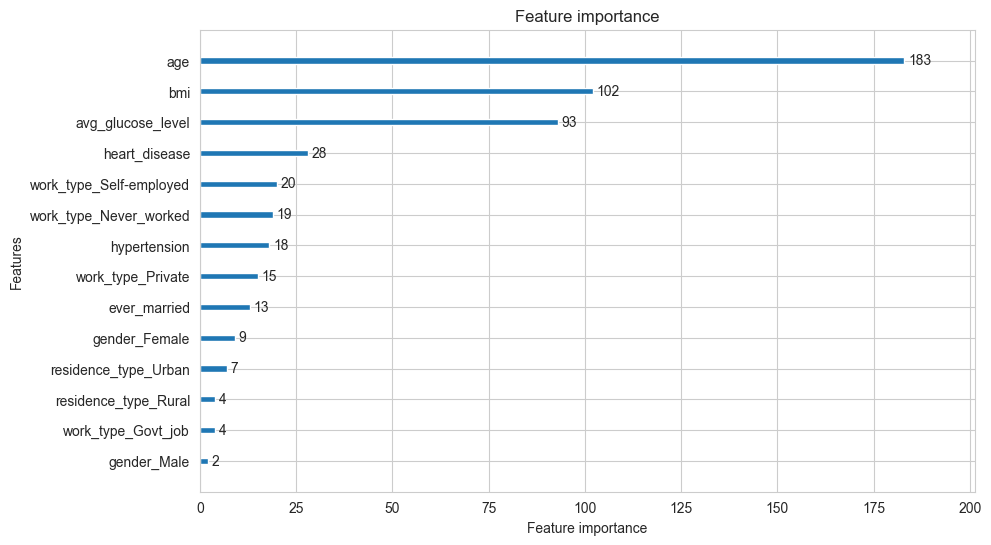

In [59]:
lgb.plot_importance(lgbm_model, figsize=(10, 6));

Just like with XGBoost the most important feature is age, but when it comes to the rest of the features, they're not all in same or similar ranges. Generally, continuous variables are the most important ones, while the rest are roughly similar, illness features being more important and residence, gender features being less important.
### SVC(rbf)

Cross-Validation Scores: [0.92478365 0.93306812 0.90394136 0.91255801 0.90719408]
Mean Recall: 0.9163090445173948
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       769
           1       0.05      0.15      0.07        40

    accuracy                           0.82       809
   macro avg       0.50      0.50      0.49       809
weighted avg       0.91      0.82      0.86       809



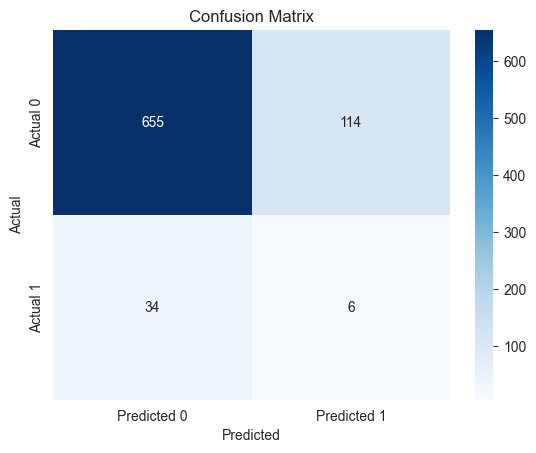

In [60]:
scaler = StandardScaler()
x_resampled1 = x_resampled.copy()
x_resampled1[["age", "avg_glucose_level", "bmi"]] = scaler.fit_transform(
    x_resampled[["age", "avg_glucose_level", "bmi"]]
)
x_val1 = x_val.copy()
x_val1[["age", "avg_glucose_level", "bmi"]] = scaler.transform(
    x_val[["age", "avg_glucose_level", "bmi"]]
)
svc_model = SVC()
param_grid = {"C": [0.1, 1, 10, 100], "kernel": ["rbf"]}
grid_search = GridSearchCV(
    svc_model, param_grid, cv=5, scoring="recall_macro", n_jobs=-1
)
grid_search.fit(x_resampled1, y_resampled)
svc_model = grid_search.best_estimator_
cv = KFold(n_splits=5, shuffle=True, random_state=1)
cv_scores = cross_val_score(
    svc_model, x_resampled1, y_resampled, cv=cv, scoring="recall_macro"
)
print("Cross-Validation Scores:", cv_scores)
print("Mean Recall:", np.mean(cv_scores))
svc_predictions = svc_model.predict(x_val1)
svc_cm = confusion_matrix(y_val, svc_predictions)
svc_report = classification_report(y_val, svc_predictions)
sns.heatmap(
    svc_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
print(svc_report)

We see that this model deals horribly with this problem having a recall of only 0.15. Looking at cross-validation results which we can see are at around 0.92 we can tell that this model is overfitting.
### SVC(polynomial)

Cross-Validation Scores: [0.87357784 0.88322894 0.86728865 0.87607286 0.8647896 ]
Mean Recall: 0.8729915782347325
              precision    recall  f1-score   support

           0       0.95      0.80      0.87       769
           1       0.06      0.25      0.10        40

    accuracy                           0.77       809
   macro avg       0.51      0.52      0.48       809
weighted avg       0.91      0.77      0.83       809



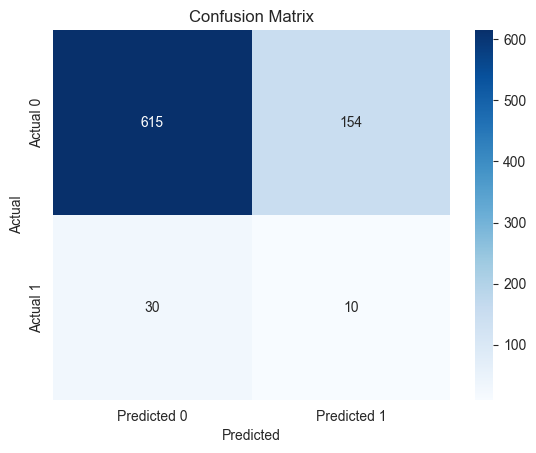

In [61]:
svc_model = SVC()
param_grid = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["poly"],
    "degree": [2, 3],
}
grid_search = GridSearchCV(
    svc_model, param_grid, cv=5, scoring="recall_macro", n_jobs=-1
)
grid_search.fit(x_resampled1, y_resampled)
svc_model = grid_search.best_estimator_
cv = KFold(n_splits=5, shuffle=True, random_state=1)
cv_scores = cross_val_score(
    svc_model, x_resampled1, y_resampled, cv=cv, scoring="recall_macro"
)
print("Cross-Validation Scores:", cv_scores)
print("Mean Recall:", np.mean(cv_scores))
svc_predictions = svc_model.predict(x_val1)
svc_cm = confusion_matrix(y_val, svc_predictions)
svc_report = classification_report(y_val, svc_predictions)
sns.heatmap(
    svc_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
print(svc_report)

Similarly, with the previous model, it's over-fitted, though it does slightly better than the SVC with rbf model.
### SVC(linear)

Cross-Validation Scores: [0.81344442 0.79032736 0.75594218 0.78980704 0.77237243]
Mean Recall: 0.7843786863655696
              precision    recall  f1-score   support

           0       0.98      0.74      0.84       769
           1       0.13      0.78      0.23        40

    accuracy                           0.74       809
   macro avg       0.56      0.76      0.54       809
weighted avg       0.94      0.74      0.81       809



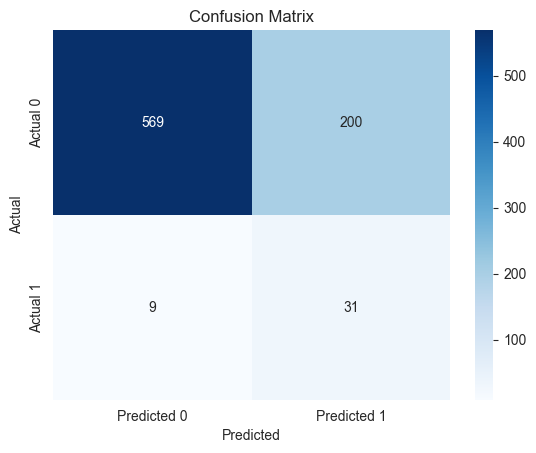

In [62]:
svc_model = SVC()
param_grid = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["linear"],
}
grid_search = GridSearchCV(
    svc_model, param_grid, cv=5, scoring="recall_macro", n_jobs=-1
)
grid_search.fit(x_resampled1, y_resampled)
svc_model = grid_search.best_estimator_
cv = KFold(n_splits=5, shuffle=True, random_state=1)
cv_scores = cross_val_score(
    svc_model, x_resampled1, y_resampled, cv=cv, scoring="recall_macro"
)
print("Cross-Validation Scores:", cv_scores)
print("Mean Recall:", np.mean(cv_scores))
svc_predictions = svc_model.predict(x_val1)
svc_cm = confusion_matrix(y_val, svc_predictions)
svc_report = classification_report(y_val, svc_predictions)
sns.heatmap(
    svc_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
print(svc_report)

This model does far better than the other SVC kernel models, almost as good as the LightGBM model. It's also not over-fitted.

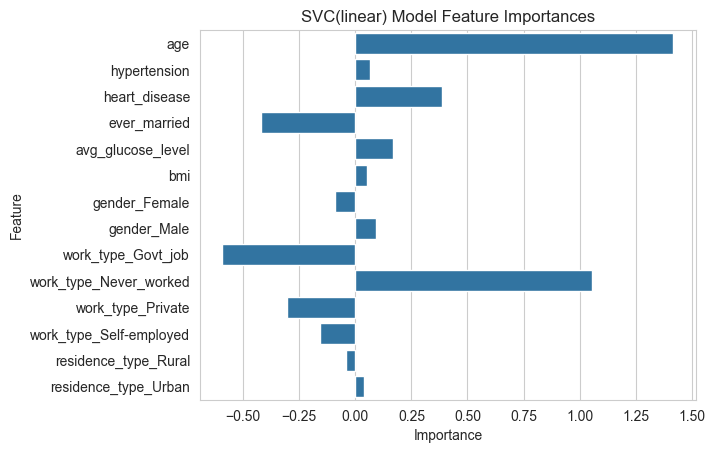

In [63]:
coefficients = svc_model.coef_[0]
feature_importance = pd.DataFrame(
    {"Feature": x_resampled1.columns, "Coef": coefficients}
)
sns.barplot(feature_importance, x="Coef", y="Feature", color="C0")
plt.title("SVC(linear) Model Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature");

Looking at feature coefficients, once again age is the most important one, though the other continuous variables aren't as important as they were int the previous models. Instead, we see that work type feature is being considered far more important than in the other models.
### Logistic Regression

Cross-Validation Scores: [0.81579365 0.79780244 0.75853643 0.79602963 0.78062325]
Mean Recall: 0.7897570804909826
              precision    recall  f1-score   support

           0       0.98      0.75      0.85       769
           1       0.14      0.78      0.24        40

    accuracy                           0.75       809
   macro avg       0.56      0.76      0.54       809
weighted avg       0.94      0.75      0.82       809



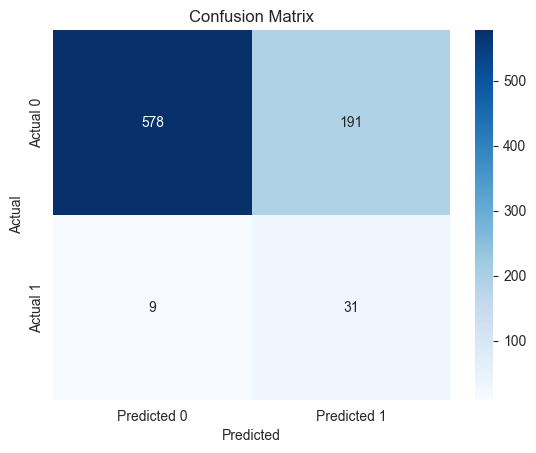

In [64]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)
logreg_model = LogisticRegression()
param_grid = {
    "penalty": ["l1", "l2", "elasticnet"],
    "C": [0.01, 0.1, 1, 10, 100],
    "fit_intercept": [True, False],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
}
grid_search = GridSearchCV(
    logreg_model, param_grid, cv=5, scoring="recall_macro", n_jobs=-1
)
grid_search.fit(x_resampled1, y_resampled)
logreg_model = grid_search.best_estimator_
cv = KFold(n_splits=5, shuffle=True, random_state=1)
cv_scores = cross_val_score(
    logreg_model, x_resampled1, y_resampled, cv=cv, scoring="recall_macro"
)
print("Cross-Validation Scores:", cv_scores)
print("Mean Recall:", np.mean(cv_scores))
logreg_predictions = logreg_model.predict(x_val1)
logreg_cm = confusion_matrix(y_val, logreg_predictions)
logreg_report = classification_report(y_val, logreg_predictions)
sns.heatmap(
    logreg_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
print(logreg_report)
warnings.resetwarnings()

Same as previous model, with slightly better precision. Not over-fitted and rather good recall.

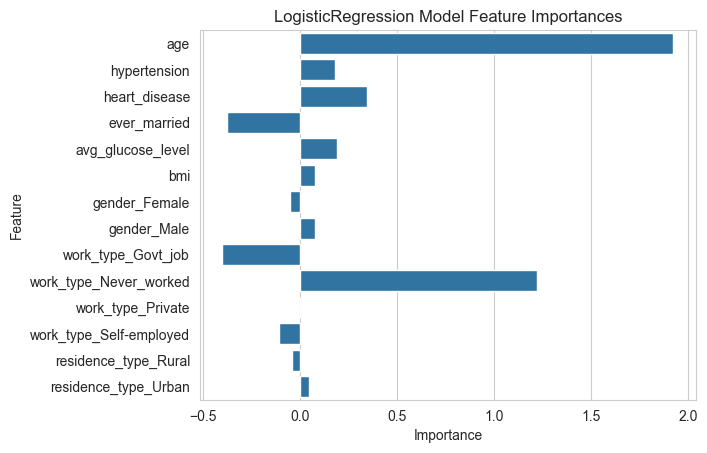

In [65]:
coefficients = logreg_model.coef_[0]
feature_importance = pd.DataFrame(
    {"Feature": x_resampled1.columns, "Coef": coefficients}
)
sns.barplot(feature_importance, x="Coef", y="Feature", color="C0")
plt.title("LogisticRegression Model Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature");

Comparing this models feature coefficients with the previous models' which were the most similar, work type and age features tend to be most important, with work type being less important in some categories, and ever married feature being more important. Other features tend to not be as important. One problem with this model is that it is sensitive to multi-collinearity, something we haven't tackled yet. That is what we're going to be investigating next.
### Tackling correlation

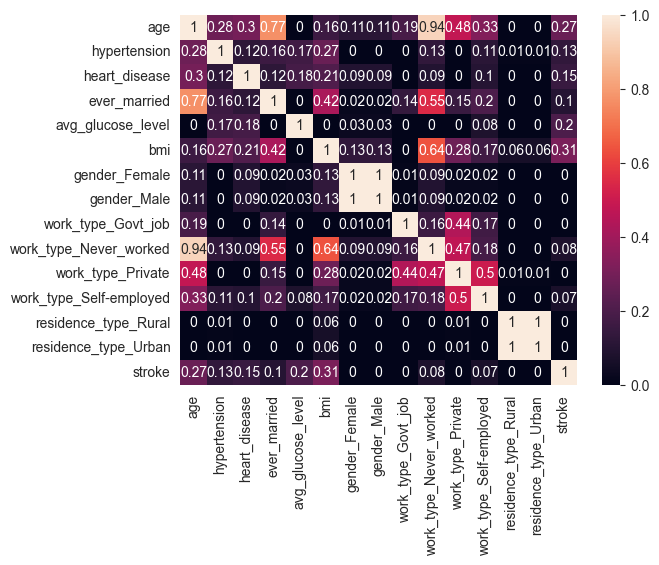

In [66]:
x_joined = x_train_copy.join(y_train)
correlation_matrix = pd.DataFrame(index=x_joined.columns, columns=x_joined.columns)
for col in x_joined.columns:
    for col2 in x_joined.columns:
        if col or col2 not in numerical_cols:
            cm = pd.crosstab(x_joined[col], x_joined[col2])
            correlation = cramers_v(cm)
            correlation_matrix.at[col, col2] = round(correlation, 2)
        else:
            correlation_matrix.at[col, col2] = round(spearmanr(col, col2)[0], 2)
correlation_matrix = correlation_matrix.astype(float)
sns.heatmap(correlation_matrix, annot=True);

We've used Cramer's V metric to measure correlation between categorical variables and Spearman rank order correlation to measure correlation between continuous and categorical or continuous variables. We can see that most features have no correlation with our target, and some even having strong correlation with age or other stronger correlated with our target feature. We'll be leaving only a few columns that have stronger correlation coefficient with the target variable in hopes of removing some noise.

Cross-Validation Scores: [0.80875653 0.7976358  0.7588141  0.79165872 0.7775292 ]
Mean Recall: 0.7868788702853726
              precision    recall  f1-score   support

           0       0.99      0.72      0.83       769
           1       0.13      0.82      0.23        40

    accuracy                           0.72       809
   macro avg       0.56      0.77      0.53       809
weighted avg       0.95      0.72      0.80       809



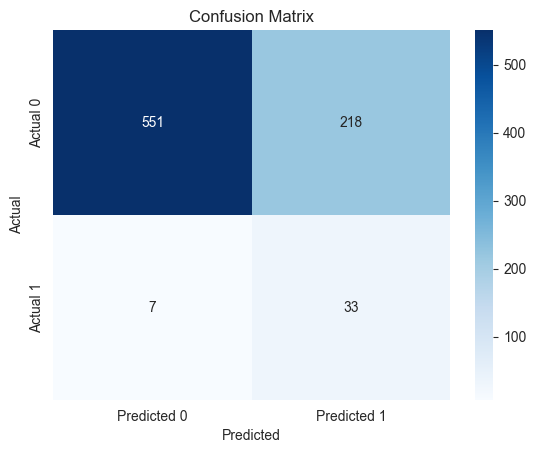

In [67]:
warnings.filterwarnings("ignore")
scaler = StandardScaler()
x_resampled2 = x_resampled[
    ["age", "hypertension", "heart_disease", "avg_glucose_level", "bmi"]
]
x_resampled2[["age", "avg_glucose_level", "bmi"]] = scaler.fit_transform(
    x_resampled2[["age", "avg_glucose_level", "bmi"]]
)
x_val2 = x_val[["age", "hypertension", "heart_disease", "avg_glucose_level", "bmi"]]
x_val2[["age", "avg_glucose_level", "bmi"]] = scaler.transform(
    x_val2[["age", "avg_glucose_level", "bmi"]]
)
logreg_model = LogisticRegression()
param_grid = {
    "penalty": ["l1", "l2", "elasticnet"],
    "C": [0.01, 0.1, 1, 10, 100],
    "fit_intercept": [True, False],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
}
grid_search = GridSearchCV(
    logreg_model, param_grid, cv=5, scoring="recall_macro", n_jobs=-1
)
grid_search.fit(x_resampled2, y_resampled)
logreg_model = grid_search.best_estimator_
cv = KFold(n_splits=5, shuffle=True, random_state=1)
cv_scores = cross_val_score(
    logreg_model, x_resampled2, y_resampled, cv=cv, scoring="recall_macro"
)
print("Cross-Validation Scores:", cv_scores)
print("Mean Recall:", np.mean(cv_scores))
logreg_predictions = logreg_model.predict(x_val2)
logreg_cm = confusion_matrix(y_val, logreg_predictions)
logreg_report = classification_report(y_val, logreg_predictions)
sns.heatmap(
    logreg_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
print(logreg_report)
warnings.resetwarnings()

In [68]:
grid_search.best_params_

{'C': 0.01, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}

After removing over half of the features that didn't seem to have a linear relationship with our feature, we see that logistic regression models' performance has increased slightly. It also doesn't seem to be overfitted.

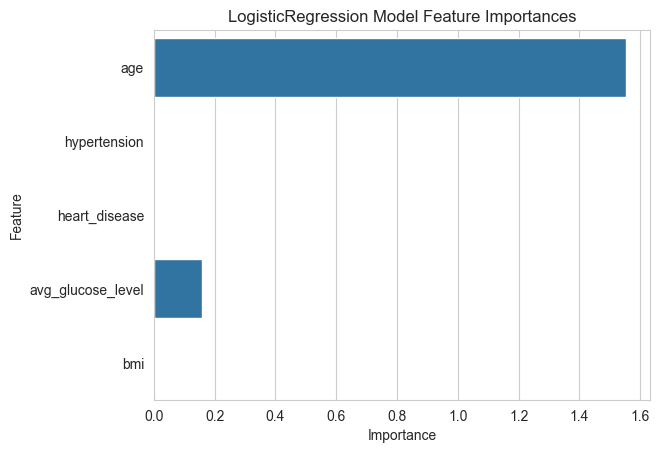

In [69]:
coefficients = logreg_model.coef_[0]
feature_importance = pd.DataFrame(
    {"Feature": x_resampled2.columns, "Coef": coefficients}
)
sns.barplot(feature_importance, x="Coef", y="Feature", color="C0")
plt.title("LogisticRegression Model Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature");

Looking at the coefficients the only relevant ones left seem to be age and average glucose level. Considering that this model had the best performance, we will be using it to predict our test set.

              precision    recall  f1-score   support

           0       0.98      0.70      0.82       933
           1       0.11      0.77      0.20        47

    accuracy                           0.70       980
   macro avg       0.55      0.73      0.51       980
weighted avg       0.94      0.70      0.79       980



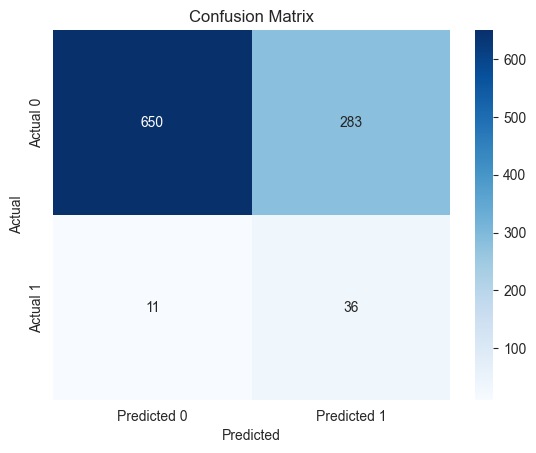

In [70]:
scaler = StandardScaler()
x_resampled3 = x_resampled[["age", "avg_glucose_level"]].copy()
x_resampled3[["age", "avg_glucose_level"]] = scaler.fit_transform(
    x_resampled3[["age", "avg_glucose_level"]]
)

x_test, y_test = drop_rows(x_test, y_test, x_test["gender"] == "Other")
x_test = x_test[x_test["bmi"] < outlier.min()]
y_test = y_test.loc[x_test.index]
x_test = x_test[["age", "avg_glucose_level"]]
x_test[["age", "avg_glucose_level"]] = scaler.transform(
    x_test[["age", "avg_glucose_level"]]
)

logreg_model = LogisticRegression(
    C=0.01, fit_intercept=True, max_iter=100, penalty="l1", solver="liblinear"
)
logreg_model.fit(x_resampled3, y_resampled)
logreg_predictions = logreg_model.predict(x_test)
logreg_cm = confusion_matrix(y_test, logreg_predictions)
logreg_report = classification_report(y_test, logreg_predictions)
sns.heatmap(
    logreg_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
print(logreg_report)

It seems that predictions made on the test set were not as good as the ones on the validation set. We can move on to building a pipeline in the next (model_building.ipynb) notebook.